In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from npDoseResponse import DRCurve
from npDoseResponse import DRDerivCurve, NeurNet, RADRDerivBC, IPWDRDerivBC, DRDRDerivBC
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

## Example 3:  RA, IPW, DR Estimations of Dose-Response Curve and its Derivative Under Positivity

We generate i.i.d. data $\{(Y_i,T_i,\mathbf{S}_i)\}_{i=1}^n$ from the following data-generating model
\begin{align*}
&Y=1.2\,T+T^2 + TS_1+1.2\,\mathbf{\xi}^T\mathbf{S} +\epsilon\cdot \sqrt{0.5+F_{\mathcal{N}(0,1)}(S_1)}, \quad \epsilon\sim \mathcal{N}(0,1),\\ 
&T= F_{\mathcal{N}(0,1)}\left(3\mathbf{\xi}^T\mathbf{S}\right) - 0.5 + 0.75E, \quad  \mathbf{S}=(S_1,...,S_d)^T \sim \mathcal{N}_d\left(\mathbf{0}, \Sigma\right), \quad E\sim \mathcal{N}(0,1),
\end{align*}
where $F_{\mathcal{N}(0,1)}$ is the CDF of $\mathcal{N}\left(0, 1\right)$, $\mathbf{\xi}=(\xi_1,...,\xi_d)^T \in \mathbb{R}^d$ has its entry $\xi_j=\frac{1}{j^2}$ for $j=1,...,d$ as well as $\Sigma_{ii}=1$, $\Sigma_{ij}=0.5$ when $|i-j|=1$, and $\Sigma_{ij}=0$ when $|i-j|>1$ for $i,j=1,...,d$. Here, $n=2000$ and $d=20$. The dose-response curve is thus given by $m(t)= 1.2t+t^2$, and our parameter of interest here is the derivative effect curve $\theta(t)=1.2+2t$.

In [2]:
rho = 0.5  # correlation between adjacent Xs
d = 20   # Dimension of the confounding variables
n = 2000

Sigma = np.zeros((d,d)) + np.eye(d)
for i in range(d):
    for j in range(i+1, d):
        if (j < i+2) or (j > i+d-2):
            Sigma[i,j] = rho
            Sigma[j,i] = rho
sig = 1

np.random.seed(123)
# Data generating process
X_sim = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
nu = np.random.randn(n)
eps = np.random.randn(n)

theta = 1/(np.linspace(1, d, d)**2)

T_sim = scipy.stats.norm.cdf(3*np.dot(X_sim, theta)) + 3*nu/4 - 1/2
Y_sim = 1.2*T_sim + T_sim**2 + T_sim*X_sim[:,0] + 1.2*np.dot(X_sim, theta) + eps*np.sqrt(0.5+ scipy.stats.norm.cdf(X_sim[:,0]))
X_dat = np.column_stack([T_sim, X_sim])

t_qry = np.linspace(-2, 2, 41)

# Choice of the bandwidth parameter
h = 4*np.std(T_sim)*n**(-1/5)

In [3]:
# RA estimator
reg_mod = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', learning_rate='adaptive', 
                       learning_rate_init=0.1, random_state=1, max_iter=200)
m_est_ra5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="RA", mu=reg_mod, 
                    L=5, h=None, kern="epanechnikov", print_bw=False)

In [4]:
# IPW estimator
regr_nn2 = MLPRegressor(hidden_layer_sizes=(20,), activation='relu', learning_rate='adaptive', 
                        learning_rate_init=0.1, random_state=1, max_iter=200)
m_est_ipw5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="IPW", mu=None, 
                     condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, h=h, 
                     kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the IPW estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [5]:
m_est_dr5, sd_est_dr5 = DRCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="DR", mu=reg_mod, 
                                condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, 
                                h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the DR estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [6]:
# RA estimator of \theta(t)
theta_ra5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                         n_iter=1000, lr=0.01, L=5, print_bw=False)

Epoch [1/1000], Loss: 10.4075
Epoch [2/1000], Loss: 9.2249
Epoch [3/1000], Loss: 7.8984
Epoch [4/1000], Loss: 6.8643
Epoch [5/1000], Loss: 6.0413
Epoch [6/1000], Loss: 5.2935
Epoch [7/1000], Loss: 4.6534
Epoch [8/1000], Loss: 4.2069
Epoch [9/1000], Loss: 3.9294
Epoch [10/1000], Loss: 3.7200
Epoch [11/1000], Loss: 3.5173
Epoch [12/1000], Loss: 3.3207
Epoch [13/1000], Loss: 3.1403
Epoch [14/1000], Loss: 2.9776
Epoch [15/1000], Loss: 2.8336
Epoch [16/1000], Loss: 2.7083
Epoch [17/1000], Loss: 2.5966
Epoch [18/1000], Loss: 2.4930
Epoch [19/1000], Loss: 2.3959
Epoch [20/1000], Loss: 2.3067
Epoch [21/1000], Loss: 2.2261
Epoch [22/1000], Loss: 2.1538
Epoch [23/1000], Loss: 2.0891
Epoch [24/1000], Loss: 2.0314
Epoch [25/1000], Loss: 1.9800
Epoch [26/1000], Loss: 1.9341
Epoch [27/1000], Loss: 1.8928
Epoch [28/1000], Loss: 1.8559
Epoch [29/1000], Loss: 1.8228
Epoch [30/1000], Loss: 1.7931
Epoch [31/1000], Loss: 1.7663
Epoch [32/1000], Loss: 1.7420
Epoch [33/1000], Loss: 1.7200
Epoch [34/1000], L

Epoch [326/1000], Loss: 0.7766
Epoch [327/1000], Loss: 0.7756
Epoch [328/1000], Loss: 0.7747
Epoch [329/1000], Loss: 0.7737
Epoch [330/1000], Loss: 0.7728
Epoch [331/1000], Loss: 0.7719
Epoch [332/1000], Loss: 0.7709
Epoch [333/1000], Loss: 0.7700
Epoch [334/1000], Loss: 0.7691
Epoch [335/1000], Loss: 0.7681
Epoch [336/1000], Loss: 0.7672
Epoch [337/1000], Loss: 0.7663
Epoch [338/1000], Loss: 0.7654
Epoch [339/1000], Loss: 0.7644
Epoch [340/1000], Loss: 0.7635
Epoch [341/1000], Loss: 0.7626
Epoch [342/1000], Loss: 0.7617
Epoch [343/1000], Loss: 0.7608
Epoch [344/1000], Loss: 0.7599
Epoch [345/1000], Loss: 0.7590
Epoch [346/1000], Loss: 0.7581
Epoch [347/1000], Loss: 0.7572
Epoch [348/1000], Loss: 0.7563
Epoch [349/1000], Loss: 0.7554
Epoch [350/1000], Loss: 0.7545
Epoch [351/1000], Loss: 0.7536
Epoch [352/1000], Loss: 0.7527
Epoch [353/1000], Loss: 0.7519
Epoch [354/1000], Loss: 0.7510
Epoch [355/1000], Loss: 0.7501
Epoch [356/1000], Loss: 0.7492
Epoch [357/1000], Loss: 0.7483
Epoch [3

Epoch [673/1000], Loss: 0.5350
Epoch [674/1000], Loss: 0.5345
Epoch [675/1000], Loss: 0.5339
Epoch [676/1000], Loss: 0.5334
Epoch [677/1000], Loss: 0.5328
Epoch [678/1000], Loss: 0.5323
Epoch [679/1000], Loss: 0.5318
Epoch [680/1000], Loss: 0.5312
Epoch [681/1000], Loss: 0.5307
Epoch [682/1000], Loss: 0.5302
Epoch [683/1000], Loss: 0.5296
Epoch [684/1000], Loss: 0.5291
Epoch [685/1000], Loss: 0.5286
Epoch [686/1000], Loss: 0.5280
Epoch [687/1000], Loss: 0.5275
Epoch [688/1000], Loss: 0.5270
Epoch [689/1000], Loss: 0.5265
Epoch [690/1000], Loss: 0.5259
Epoch [691/1000], Loss: 0.5254
Epoch [692/1000], Loss: 0.5249
Epoch [693/1000], Loss: 0.5244
Epoch [694/1000], Loss: 0.5238
Epoch [695/1000], Loss: 0.5233
Epoch [696/1000], Loss: 0.5228
Epoch [697/1000], Loss: 0.5223
Epoch [698/1000], Loss: 0.5217
Epoch [699/1000], Loss: 0.5212
Epoch [700/1000], Loss: 0.5207
Epoch [701/1000], Loss: 0.5202
Epoch [702/1000], Loss: 0.5196
Epoch [703/1000], Loss: 0.5191
Epoch [704/1000], Loss: 0.5186
Epoch [7

Epoch [941/1000], Loss: 0.4099
Epoch [942/1000], Loss: 0.4095
Epoch [943/1000], Loss: 0.4091
Epoch [944/1000], Loss: 0.4087
Epoch [945/1000], Loss: 0.4083
Epoch [946/1000], Loss: 0.4079
Epoch [947/1000], Loss: 0.4075
Epoch [948/1000], Loss: 0.4070
Epoch [949/1000], Loss: 0.4066
Epoch [950/1000], Loss: 0.4062
Epoch [951/1000], Loss: 0.4058
Epoch [952/1000], Loss: 0.4054
Epoch [953/1000], Loss: 0.4050
Epoch [954/1000], Loss: 0.4046
Epoch [955/1000], Loss: 0.4042
Epoch [956/1000], Loss: 0.4038
Epoch [957/1000], Loss: 0.4034
Epoch [958/1000], Loss: 0.4030
Epoch [959/1000], Loss: 0.4026
Epoch [960/1000], Loss: 0.4022
Epoch [961/1000], Loss: 0.4018
Epoch [962/1000], Loss: 0.4014
Epoch [963/1000], Loss: 0.4010
Epoch [964/1000], Loss: 0.4006
Epoch [965/1000], Loss: 0.4002
Epoch [966/1000], Loss: 0.3998
Epoch [967/1000], Loss: 0.3994
Epoch [968/1000], Loss: 0.3990
Epoch [969/1000], Loss: 0.3987
Epoch [970/1000], Loss: 0.3983
Epoch [971/1000], Loss: 0.3979
Epoch [972/1000], Loss: 0.3975
Epoch [9

Epoch [239/1000], Loss: 0.9115
Epoch [240/1000], Loss: 0.9103
Epoch [241/1000], Loss: 0.9091
Epoch [242/1000], Loss: 0.9080
Epoch [243/1000], Loss: 0.9068
Epoch [244/1000], Loss: 0.9056
Epoch [245/1000], Loss: 0.9045
Epoch [246/1000], Loss: 0.9033
Epoch [247/1000], Loss: 0.9021
Epoch [248/1000], Loss: 0.9010
Epoch [249/1000], Loss: 0.8999
Epoch [250/1000], Loss: 0.8987
Epoch [251/1000], Loss: 0.8976
Epoch [252/1000], Loss: 0.8965
Epoch [253/1000], Loss: 0.8954
Epoch [254/1000], Loss: 0.8942
Epoch [255/1000], Loss: 0.8931
Epoch [256/1000], Loss: 0.8920
Epoch [257/1000], Loss: 0.8909
Epoch [258/1000], Loss: 0.8898
Epoch [259/1000], Loss: 0.8887
Epoch [260/1000], Loss: 0.8877
Epoch [261/1000], Loss: 0.8866
Epoch [262/1000], Loss: 0.8855
Epoch [263/1000], Loss: 0.8844
Epoch [264/1000], Loss: 0.8833
Epoch [265/1000], Loss: 0.8823
Epoch [266/1000], Loss: 0.8812
Epoch [267/1000], Loss: 0.8802
Epoch [268/1000], Loss: 0.8791
Epoch [269/1000], Loss: 0.8781
Epoch [270/1000], Loss: 0.8770
Epoch [2

Epoch [556/1000], Loss: 0.6587
Epoch [557/1000], Loss: 0.6581
Epoch [558/1000], Loss: 0.6575
Epoch [559/1000], Loss: 0.6569
Epoch [560/1000], Loss: 0.6563
Epoch [561/1000], Loss: 0.6556
Epoch [562/1000], Loss: 0.6550
Epoch [563/1000], Loss: 0.6544
Epoch [564/1000], Loss: 0.6538
Epoch [565/1000], Loss: 0.6532
Epoch [566/1000], Loss: 0.6525
Epoch [567/1000], Loss: 0.6519
Epoch [568/1000], Loss: 0.6513
Epoch [569/1000], Loss: 0.6507
Epoch [570/1000], Loss: 0.6501
Epoch [571/1000], Loss: 0.6495
Epoch [572/1000], Loss: 0.6489
Epoch [573/1000], Loss: 0.6482
Epoch [574/1000], Loss: 0.6476
Epoch [575/1000], Loss: 0.6470
Epoch [576/1000], Loss: 0.6464
Epoch [577/1000], Loss: 0.6458
Epoch [578/1000], Loss: 0.6452
Epoch [579/1000], Loss: 0.6446
Epoch [580/1000], Loss: 0.6440
Epoch [581/1000], Loss: 0.6434
Epoch [582/1000], Loss: 0.6428
Epoch [583/1000], Loss: 0.6421
Epoch [584/1000], Loss: 0.6415
Epoch [585/1000], Loss: 0.6409
Epoch [586/1000], Loss: 0.6403
Epoch [587/1000], Loss: 0.6397
Epoch [5

Epoch [831/1000], Loss: 0.5053
Epoch [832/1000], Loss: 0.5048
Epoch [833/1000], Loss: 0.5043
Epoch [834/1000], Loss: 0.5038
Epoch [835/1000], Loss: 0.5033
Epoch [836/1000], Loss: 0.5028
Epoch [837/1000], Loss: 0.5023
Epoch [838/1000], Loss: 0.5018
Epoch [839/1000], Loss: 0.5013
Epoch [840/1000], Loss: 0.5009
Epoch [841/1000], Loss: 0.5004
Epoch [842/1000], Loss: 0.4999
Epoch [843/1000], Loss: 0.4994
Epoch [844/1000], Loss: 0.4989
Epoch [845/1000], Loss: 0.4984
Epoch [846/1000], Loss: 0.4979
Epoch [847/1000], Loss: 0.4974
Epoch [848/1000], Loss: 0.4969
Epoch [849/1000], Loss: 0.4964
Epoch [850/1000], Loss: 0.4959
Epoch [851/1000], Loss: 0.4954
Epoch [852/1000], Loss: 0.4950
Epoch [853/1000], Loss: 0.4945
Epoch [854/1000], Loss: 0.4940
Epoch [855/1000], Loss: 0.4935
Epoch [856/1000], Loss: 0.4930
Epoch [857/1000], Loss: 0.4925
Epoch [858/1000], Loss: 0.4920
Epoch [859/1000], Loss: 0.4916
Epoch [860/1000], Loss: 0.4911
Epoch [861/1000], Loss: 0.4906
Epoch [862/1000], Loss: 0.4901
Epoch [8

Epoch [170/1000], Loss: 0.9287
Epoch [171/1000], Loss: 0.9271
Epoch [172/1000], Loss: 0.9255
Epoch [173/1000], Loss: 0.9239
Epoch [174/1000], Loss: 0.9224
Epoch [175/1000], Loss: 0.9208
Epoch [176/1000], Loss: 0.9193
Epoch [177/1000], Loss: 0.9177
Epoch [178/1000], Loss: 0.9162
Epoch [179/1000], Loss: 0.9147
Epoch [180/1000], Loss: 0.9132
Epoch [181/1000], Loss: 0.9117
Epoch [182/1000], Loss: 0.9103
Epoch [183/1000], Loss: 0.9088
Epoch [184/1000], Loss: 0.9073
Epoch [185/1000], Loss: 0.9059
Epoch [186/1000], Loss: 0.9045
Epoch [187/1000], Loss: 0.9030
Epoch [188/1000], Loss: 0.9016
Epoch [189/1000], Loss: 0.9002
Epoch [190/1000], Loss: 0.8988
Epoch [191/1000], Loss: 0.8974
Epoch [192/1000], Loss: 0.8961
Epoch [193/1000], Loss: 0.8947
Epoch [194/1000], Loss: 0.8933
Epoch [195/1000], Loss: 0.8920
Epoch [196/1000], Loss: 0.8907
Epoch [197/1000], Loss: 0.8893
Epoch [198/1000], Loss: 0.8880
Epoch [199/1000], Loss: 0.8867
Epoch [200/1000], Loss: 0.8854
Epoch [201/1000], Loss: 0.8841
Epoch [2

Epoch [511/1000], Loss: 0.6295
Epoch [512/1000], Loss: 0.6289
Epoch [513/1000], Loss: 0.6283
Epoch [514/1000], Loss: 0.6276
Epoch [515/1000], Loss: 0.6270
Epoch [516/1000], Loss: 0.6264
Epoch [517/1000], Loss: 0.6258
Epoch [518/1000], Loss: 0.6252
Epoch [519/1000], Loss: 0.6245
Epoch [520/1000], Loss: 0.6239
Epoch [521/1000], Loss: 0.6233
Epoch [522/1000], Loss: 0.6227
Epoch [523/1000], Loss: 0.6221
Epoch [524/1000], Loss: 0.6215
Epoch [525/1000], Loss: 0.6208
Epoch [526/1000], Loss: 0.6202
Epoch [527/1000], Loss: 0.6196
Epoch [528/1000], Loss: 0.6190
Epoch [529/1000], Loss: 0.6184
Epoch [530/1000], Loss: 0.6178
Epoch [531/1000], Loss: 0.6172
Epoch [532/1000], Loss: 0.6166
Epoch [533/1000], Loss: 0.6160
Epoch [534/1000], Loss: 0.6153
Epoch [535/1000], Loss: 0.6147
Epoch [536/1000], Loss: 0.6141
Epoch [537/1000], Loss: 0.6135
Epoch [538/1000], Loss: 0.6129
Epoch [539/1000], Loss: 0.6123
Epoch [540/1000], Loss: 0.6117
Epoch [541/1000], Loss: 0.6111
Epoch [542/1000], Loss: 0.6105
Epoch [5

Epoch [781/1000], Loss: 0.4832
Epoch [782/1000], Loss: 0.4827
Epoch [783/1000], Loss: 0.4823
Epoch [784/1000], Loss: 0.4818
Epoch [785/1000], Loss: 0.4813
Epoch [786/1000], Loss: 0.4809
Epoch [787/1000], Loss: 0.4804
Epoch [788/1000], Loss: 0.4799
Epoch [789/1000], Loss: 0.4795
Epoch [790/1000], Loss: 0.4790
Epoch [791/1000], Loss: 0.4785
Epoch [792/1000], Loss: 0.4781
Epoch [793/1000], Loss: 0.4776
Epoch [794/1000], Loss: 0.4771
Epoch [795/1000], Loss: 0.4767
Epoch [796/1000], Loss: 0.4762
Epoch [797/1000], Loss: 0.4757
Epoch [798/1000], Loss: 0.4753
Epoch [799/1000], Loss: 0.4748
Epoch [800/1000], Loss: 0.4744
Epoch [801/1000], Loss: 0.4739
Epoch [802/1000], Loss: 0.4734
Epoch [803/1000], Loss: 0.4730
Epoch [804/1000], Loss: 0.4725
Epoch [805/1000], Loss: 0.4721
Epoch [806/1000], Loss: 0.4716
Epoch [807/1000], Loss: 0.4711
Epoch [808/1000], Loss: 0.4707
Epoch [809/1000], Loss: 0.4702
Epoch [810/1000], Loss: 0.4698
Epoch [811/1000], Loss: 0.4693
Epoch [812/1000], Loss: 0.4689
Epoch [8

Epoch [77/1000], Loss: 1.3360
Epoch [78/1000], Loss: 1.3301
Epoch [79/1000], Loss: 1.3243
Epoch [80/1000], Loss: 1.3186
Epoch [81/1000], Loss: 1.3130
Epoch [82/1000], Loss: 1.3074
Epoch [83/1000], Loss: 1.3020
Epoch [84/1000], Loss: 1.2966
Epoch [85/1000], Loss: 1.2913
Epoch [86/1000], Loss: 1.2861
Epoch [87/1000], Loss: 1.2809
Epoch [88/1000], Loss: 1.2758
Epoch [89/1000], Loss: 1.2708
Epoch [90/1000], Loss: 1.2658
Epoch [91/1000], Loss: 1.2609
Epoch [92/1000], Loss: 1.2560
Epoch [93/1000], Loss: 1.2512
Epoch [94/1000], Loss: 1.2464
Epoch [95/1000], Loss: 1.2417
Epoch [96/1000], Loss: 1.2370
Epoch [97/1000], Loss: 1.2324
Epoch [98/1000], Loss: 1.2279
Epoch [99/1000], Loss: 1.2233
Epoch [100/1000], Loss: 1.2189
Epoch [101/1000], Loss: 1.2144
Epoch [102/1000], Loss: 1.2100
Epoch [103/1000], Loss: 1.2057
Epoch [104/1000], Loss: 1.2014
Epoch [105/1000], Loss: 1.1971
Epoch [106/1000], Loss: 1.1929
Epoch [107/1000], Loss: 1.1887
Epoch [108/1000], Loss: 1.1845
Epoch [109/1000], Loss: 1.1804


Epoch [432/1000], Loss: 0.6808
Epoch [433/1000], Loss: 0.6801
Epoch [434/1000], Loss: 0.6794
Epoch [435/1000], Loss: 0.6787
Epoch [436/1000], Loss: 0.6780
Epoch [437/1000], Loss: 0.6773
Epoch [438/1000], Loss: 0.6766
Epoch [439/1000], Loss: 0.6759
Epoch [440/1000], Loss: 0.6752
Epoch [441/1000], Loss: 0.6745
Epoch [442/1000], Loss: 0.6738
Epoch [443/1000], Loss: 0.6732
Epoch [444/1000], Loss: 0.6725
Epoch [445/1000], Loss: 0.6718
Epoch [446/1000], Loss: 0.6711
Epoch [447/1000], Loss: 0.6704
Epoch [448/1000], Loss: 0.6697
Epoch [449/1000], Loss: 0.6691
Epoch [450/1000], Loss: 0.6684
Epoch [451/1000], Loss: 0.6677
Epoch [452/1000], Loss: 0.6670
Epoch [453/1000], Loss: 0.6663
Epoch [454/1000], Loss: 0.6657
Epoch [455/1000], Loss: 0.6650
Epoch [456/1000], Loss: 0.6643
Epoch [457/1000], Loss: 0.6637
Epoch [458/1000], Loss: 0.6630
Epoch [459/1000], Loss: 0.6623
Epoch [460/1000], Loss: 0.6617
Epoch [461/1000], Loss: 0.6610
Epoch [462/1000], Loss: 0.6603
Epoch [463/1000], Loss: 0.6597
Epoch [4

Epoch [700/1000], Loss: 0.5280
Epoch [701/1000], Loss: 0.5275
Epoch [702/1000], Loss: 0.5270
Epoch [703/1000], Loss: 0.5266
Epoch [704/1000], Loss: 0.5261
Epoch [705/1000], Loss: 0.5256
Epoch [706/1000], Loss: 0.5251
Epoch [707/1000], Loss: 0.5247
Epoch [708/1000], Loss: 0.5242
Epoch [709/1000], Loss: 0.5237
Epoch [710/1000], Loss: 0.5232
Epoch [711/1000], Loss: 0.5228
Epoch [712/1000], Loss: 0.5223
Epoch [713/1000], Loss: 0.5218
Epoch [714/1000], Loss: 0.5213
Epoch [715/1000], Loss: 0.5209
Epoch [716/1000], Loss: 0.5204
Epoch [717/1000], Loss: 0.5199
Epoch [718/1000], Loss: 0.5195
Epoch [719/1000], Loss: 0.5190
Epoch [720/1000], Loss: 0.5185
Epoch [721/1000], Loss: 0.5180
Epoch [722/1000], Loss: 0.5176
Epoch [723/1000], Loss: 0.5171
Epoch [724/1000], Loss: 0.5166
Epoch [725/1000], Loss: 0.5162
Epoch [726/1000], Loss: 0.5157
Epoch [727/1000], Loss: 0.5152
Epoch [728/1000], Loss: 0.5148
Epoch [729/1000], Loss: 0.5143
Epoch [730/1000], Loss: 0.5138
Epoch [731/1000], Loss: 0.5134
Epoch [7

Epoch [972/1000], Loss: 0.4121
Epoch [973/1000], Loss: 0.4117
Epoch [974/1000], Loss: 0.4113
Epoch [975/1000], Loss: 0.4109
Epoch [976/1000], Loss: 0.4106
Epoch [977/1000], Loss: 0.4102
Epoch [978/1000], Loss: 0.4098
Epoch [979/1000], Loss: 0.4094
Epoch [980/1000], Loss: 0.4090
Epoch [981/1000], Loss: 0.4087
Epoch [982/1000], Loss: 0.4083
Epoch [983/1000], Loss: 0.4079
Epoch [984/1000], Loss: 0.4075
Epoch [985/1000], Loss: 0.4072
Epoch [986/1000], Loss: 0.4068
Epoch [987/1000], Loss: 0.4064
Epoch [988/1000], Loss: 0.4060
Epoch [989/1000], Loss: 0.4057
Epoch [990/1000], Loss: 0.4053
Epoch [991/1000], Loss: 0.4049
Epoch [992/1000], Loss: 0.4045
Epoch [993/1000], Loss: 0.4042
Epoch [994/1000], Loss: 0.4038
Epoch [995/1000], Loss: 0.4034
Epoch [996/1000], Loss: 0.4030
Epoch [997/1000], Loss: 0.4027
Epoch [998/1000], Loss: 0.4023
Epoch [999/1000], Loss: 0.4019
Epoch [1000/1000], Loss: 0.4016
Epoch [1/1000], Loss: 8.9711
Epoch [2/1000], Loss: 7.7841
Epoch [3/1000], Loss: 6.4604
Epoch [4/1000

Epoch [241/1000], Loss: 0.9153
Epoch [242/1000], Loss: 0.9142
Epoch [243/1000], Loss: 0.9132
Epoch [244/1000], Loss: 0.9122
Epoch [245/1000], Loss: 0.9111
Epoch [246/1000], Loss: 0.9101
Epoch [247/1000], Loss: 0.9091
Epoch [248/1000], Loss: 0.9080
Epoch [249/1000], Loss: 0.9070
Epoch [250/1000], Loss: 0.9060
Epoch [251/1000], Loss: 0.9050
Epoch [252/1000], Loss: 0.9040
Epoch [253/1000], Loss: 0.9030
Epoch [254/1000], Loss: 0.9020
Epoch [255/1000], Loss: 0.9010
Epoch [256/1000], Loss: 0.9000
Epoch [257/1000], Loss: 0.8990
Epoch [258/1000], Loss: 0.8980
Epoch [259/1000], Loss: 0.8970
Epoch [260/1000], Loss: 0.8961
Epoch [261/1000], Loss: 0.8951
Epoch [262/1000], Loss: 0.8941
Epoch [263/1000], Loss: 0.8931
Epoch [264/1000], Loss: 0.8922
Epoch [265/1000], Loss: 0.8912
Epoch [266/1000], Loss: 0.8902
Epoch [267/1000], Loss: 0.8893
Epoch [268/1000], Loss: 0.8883
Epoch [269/1000], Loss: 0.8874
Epoch [270/1000], Loss: 0.8864
Epoch [271/1000], Loss: 0.8855
Epoch [272/1000], Loss: 0.8845
Epoch [2

Epoch [508/1000], Loss: 0.7052
Epoch [509/1000], Loss: 0.7046
Epoch [510/1000], Loss: 0.7039
Epoch [511/1000], Loss: 0.7033
Epoch [512/1000], Loss: 0.7026
Epoch [513/1000], Loss: 0.7020
Epoch [514/1000], Loss: 0.7014
Epoch [515/1000], Loss: 0.7007
Epoch [516/1000], Loss: 0.7001
Epoch [517/1000], Loss: 0.6994
Epoch [518/1000], Loss: 0.6988
Epoch [519/1000], Loss: 0.6981
Epoch [520/1000], Loss: 0.6975
Epoch [521/1000], Loss: 0.6969
Epoch [522/1000], Loss: 0.6962
Epoch [523/1000], Loss: 0.6956
Epoch [524/1000], Loss: 0.6949
Epoch [525/1000], Loss: 0.6943
Epoch [526/1000], Loss: 0.6937
Epoch [527/1000], Loss: 0.6930
Epoch [528/1000], Loss: 0.6924
Epoch [529/1000], Loss: 0.6917
Epoch [530/1000], Loss: 0.6911
Epoch [531/1000], Loss: 0.6905
Epoch [532/1000], Loss: 0.6898
Epoch [533/1000], Loss: 0.6892
Epoch [534/1000], Loss: 0.6886
Epoch [535/1000], Loss: 0.6879
Epoch [536/1000], Loss: 0.6873
Epoch [537/1000], Loss: 0.6867
Epoch [538/1000], Loss: 0.6860
Epoch [539/1000], Loss: 0.6854
Epoch [5

Epoch [848/1000], Loss: 0.5120
Epoch [849/1000], Loss: 0.5115
Epoch [850/1000], Loss: 0.5110
Epoch [851/1000], Loss: 0.5105
Epoch [852/1000], Loss: 0.5100
Epoch [853/1000], Loss: 0.5095
Epoch [854/1000], Loss: 0.5090
Epoch [855/1000], Loss: 0.5085
Epoch [856/1000], Loss: 0.5080
Epoch [857/1000], Loss: 0.5075
Epoch [858/1000], Loss: 0.5070
Epoch [859/1000], Loss: 0.5065
Epoch [860/1000], Loss: 0.5060
Epoch [861/1000], Loss: 0.5055
Epoch [862/1000], Loss: 0.5050
Epoch [863/1000], Loss: 0.5045
Epoch [864/1000], Loss: 0.5040
Epoch [865/1000], Loss: 0.5035
Epoch [866/1000], Loss: 0.5030
Epoch [867/1000], Loss: 0.5025
Epoch [868/1000], Loss: 0.5020
Epoch [869/1000], Loss: 0.5016
Epoch [870/1000], Loss: 0.5011
Epoch [871/1000], Loss: 0.5006
Epoch [872/1000], Loss: 0.5001
Epoch [873/1000], Loss: 0.4996
Epoch [874/1000], Loss: 0.4991
Epoch [875/1000], Loss: 0.4986
Epoch [876/1000], Loss: 0.4981
Epoch [877/1000], Loss: 0.4976
Epoch [878/1000], Loss: 0.4971
Epoch [879/1000], Loss: 0.4966
Epoch [8

In [7]:
# IPW estimator of \theta(t)
theta_ipw5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="IPW", beta_mod=None, 
                          condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, L=5, 
                          h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the IPW estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

The current bandwidth for KDE is 0.28090411097493984.

The current bandwidth for KDE is 0.2679859487988173.

The current bandwidth for KDE is 0.27450789972131157.

The current bandwidth for KDE is 0.2771505691728006.



In [8]:
# DR estimator of \theta(t)
theta_dr5, theta_sd5 = DRDerivCurve(Y=Y_sim, X=X_dat, t_eval=t_qry, est="DR", beta_mod=NeurNet, 
                                    n_iter=1000, lr=0.01, condTS_type='kde', condTS_mod=regr_nn2, tau=0.001, 
                                    L=5, h=h, kern="epanechnikov", h_cond=None, self_norm=True, print_bw=True)

The current bandwidth for the DR estimator is 0.7621626742251334.

The current bandwidth for KDE is 0.2766293896223984.

Epoch [1/1000], Loss: 9.4872
Epoch [2/1000], Loss: 7.9671
Epoch [3/1000], Loss: 6.8663
Epoch [4/1000], Loss: 6.4097
Epoch [5/1000], Loss: 5.8075
Epoch [6/1000], Loss: 4.9994
Epoch [7/1000], Loss: 4.4626
Epoch [8/1000], Loss: 4.2068
Epoch [9/1000], Loss: 3.9660
Epoch [10/1000], Loss: 3.7180
Epoch [11/1000], Loss: 3.5402
Epoch [12/1000], Loss: 3.3733
Epoch [13/1000], Loss: 3.1864
Epoch [14/1000], Loss: 3.0304
Epoch [15/1000], Loss: 2.9075
Epoch [16/1000], Loss: 2.7925
Epoch [17/1000], Loss: 2.6883
Epoch [18/1000], Loss: 2.5994
Epoch [19/1000], Loss: 2.5169
Epoch [20/1000], Loss: 2.4372
Epoch [21/1000], Loss: 2.3635
Epoch [22/1000], Loss: 2.2949
Epoch [23/1000], Loss: 2.2295
Epoch [24/1000], Loss: 2.1682
Epoch [25/1000], Loss: 2.1112
Epoch [26/1000], Loss: 2.0577
Epoch [27/1000], Loss: 2.0075
Epoch [28/1000], Loss: 1.9607
Epoch [29/1000], Loss: 1.9171
Epoch [30/1000], L

Epoch [294/1000], Loss: 0.7993
Epoch [295/1000], Loss: 0.7984
Epoch [296/1000], Loss: 0.7975
Epoch [297/1000], Loss: 0.7966
Epoch [298/1000], Loss: 0.7957
Epoch [299/1000], Loss: 0.7948
Epoch [300/1000], Loss: 0.7939
Epoch [301/1000], Loss: 0.7930
Epoch [302/1000], Loss: 0.7921
Epoch [303/1000], Loss: 0.7912
Epoch [304/1000], Loss: 0.7904
Epoch [305/1000], Loss: 0.7895
Epoch [306/1000], Loss: 0.7886
Epoch [307/1000], Loss: 0.7877
Epoch [308/1000], Loss: 0.7868
Epoch [309/1000], Loss: 0.7860
Epoch [310/1000], Loss: 0.7851
Epoch [311/1000], Loss: 0.7842
Epoch [312/1000], Loss: 0.7833
Epoch [313/1000], Loss: 0.7825
Epoch [314/1000], Loss: 0.7816
Epoch [315/1000], Loss: 0.7807
Epoch [316/1000], Loss: 0.7799
Epoch [317/1000], Loss: 0.7790
Epoch [318/1000], Loss: 0.7782
Epoch [319/1000], Loss: 0.7773
Epoch [320/1000], Loss: 0.7764
Epoch [321/1000], Loss: 0.7756
Epoch [322/1000], Loss: 0.7747
Epoch [323/1000], Loss: 0.7739
Epoch [324/1000], Loss: 0.7731
Epoch [325/1000], Loss: 0.7722
Epoch [3

Epoch [560/1000], Loss: 0.6100
Epoch [561/1000], Loss: 0.6094
Epoch [562/1000], Loss: 0.6088
Epoch [563/1000], Loss: 0.6083
Epoch [564/1000], Loss: 0.6077
Epoch [565/1000], Loss: 0.6071
Epoch [566/1000], Loss: 0.6065
Epoch [567/1000], Loss: 0.6059
Epoch [568/1000], Loss: 0.6054
Epoch [569/1000], Loss: 0.6048
Epoch [570/1000], Loss: 0.6042
Epoch [571/1000], Loss: 0.6036
Epoch [572/1000], Loss: 0.6030
Epoch [573/1000], Loss: 0.6025
Epoch [574/1000], Loss: 0.6019
Epoch [575/1000], Loss: 0.6013
Epoch [576/1000], Loss: 0.6007
Epoch [577/1000], Loss: 0.6002
Epoch [578/1000], Loss: 0.5996
Epoch [579/1000], Loss: 0.5990
Epoch [580/1000], Loss: 0.5985
Epoch [581/1000], Loss: 0.5979
Epoch [582/1000], Loss: 0.5973
Epoch [583/1000], Loss: 0.5967
Epoch [584/1000], Loss: 0.5962
Epoch [585/1000], Loss: 0.5956
Epoch [586/1000], Loss: 0.5950
Epoch [587/1000], Loss: 0.5945
Epoch [588/1000], Loss: 0.5939
Epoch [589/1000], Loss: 0.5933
Epoch [590/1000], Loss: 0.5928
Epoch [591/1000], Loss: 0.5922
Epoch [5

Epoch [829/1000], Loss: 0.4716
Epoch [830/1000], Loss: 0.4711
Epoch [831/1000], Loss: 0.4707
Epoch [832/1000], Loss: 0.4702
Epoch [833/1000], Loss: 0.4698
Epoch [834/1000], Loss: 0.4693
Epoch [835/1000], Loss: 0.4689
Epoch [836/1000], Loss: 0.4684
Epoch [837/1000], Loss: 0.4679
Epoch [838/1000], Loss: 0.4675
Epoch [839/1000], Loss: 0.4670
Epoch [840/1000], Loss: 0.4666
Epoch [841/1000], Loss: 0.4661
Epoch [842/1000], Loss: 0.4657
Epoch [843/1000], Loss: 0.4652
Epoch [844/1000], Loss: 0.4648
Epoch [845/1000], Loss: 0.4643
Epoch [846/1000], Loss: 0.4639
Epoch [847/1000], Loss: 0.4634
Epoch [848/1000], Loss: 0.4630
Epoch [849/1000], Loss: 0.4626
Epoch [850/1000], Loss: 0.4621
Epoch [851/1000], Loss: 0.4617
Epoch [852/1000], Loss: 0.4612
Epoch [853/1000], Loss: 0.4608
Epoch [854/1000], Loss: 0.4603
Epoch [855/1000], Loss: 0.4599
Epoch [856/1000], Loss: 0.4594
Epoch [857/1000], Loss: 0.4590
Epoch [858/1000], Loss: 0.4585
Epoch [859/1000], Loss: 0.4581
Epoch [860/1000], Loss: 0.4577
Epoch [8

Epoch [156/1000], Loss: 0.9639
Epoch [157/1000], Loss: 0.9619
Epoch [158/1000], Loss: 0.9599
Epoch [159/1000], Loss: 0.9580
Epoch [160/1000], Loss: 0.9561
Epoch [161/1000], Loss: 0.9542
Epoch [162/1000], Loss: 0.9523
Epoch [163/1000], Loss: 0.9504
Epoch [164/1000], Loss: 0.9486
Epoch [165/1000], Loss: 0.9467
Epoch [166/1000], Loss: 0.9449
Epoch [167/1000], Loss: 0.9431
Epoch [168/1000], Loss: 0.9413
Epoch [169/1000], Loss: 0.9395
Epoch [170/1000], Loss: 0.9378
Epoch [171/1000], Loss: 0.9361
Epoch [172/1000], Loss: 0.9343
Epoch [173/1000], Loss: 0.9326
Epoch [174/1000], Loss: 0.9309
Epoch [175/1000], Loss: 0.9292
Epoch [176/1000], Loss: 0.9276
Epoch [177/1000], Loss: 0.9259
Epoch [178/1000], Loss: 0.9243
Epoch [179/1000], Loss: 0.9226
Epoch [180/1000], Loss: 0.9210
Epoch [181/1000], Loss: 0.9194
Epoch [182/1000], Loss: 0.9178
Epoch [183/1000], Loss: 0.9162
Epoch [184/1000], Loss: 0.9147
Epoch [185/1000], Loss: 0.9131
Epoch [186/1000], Loss: 0.9116
Epoch [187/1000], Loss: 0.9101
Epoch [1

Epoch [500/1000], Loss: 0.6381
Epoch [501/1000], Loss: 0.6374
Epoch [502/1000], Loss: 0.6368
Epoch [503/1000], Loss: 0.6362
Epoch [504/1000], Loss: 0.6356
Epoch [505/1000], Loss: 0.6350
Epoch [506/1000], Loss: 0.6344
Epoch [507/1000], Loss: 0.6337
Epoch [508/1000], Loss: 0.6331
Epoch [509/1000], Loss: 0.6325
Epoch [510/1000], Loss: 0.6319
Epoch [511/1000], Loss: 0.6313
Epoch [512/1000], Loss: 0.6307
Epoch [513/1000], Loss: 0.6301
Epoch [514/1000], Loss: 0.6295
Epoch [515/1000], Loss: 0.6288
Epoch [516/1000], Loss: 0.6282
Epoch [517/1000], Loss: 0.6276
Epoch [518/1000], Loss: 0.6270
Epoch [519/1000], Loss: 0.6264
Epoch [520/1000], Loss: 0.6258
Epoch [521/1000], Loss: 0.6252
Epoch [522/1000], Loss: 0.6246
Epoch [523/1000], Loss: 0.6240
Epoch [524/1000], Loss: 0.6234
Epoch [525/1000], Loss: 0.6228
Epoch [526/1000], Loss: 0.6222
Epoch [527/1000], Loss: 0.6216
Epoch [528/1000], Loss: 0.6210
Epoch [529/1000], Loss: 0.6204
Epoch [530/1000], Loss: 0.6198
Epoch [531/1000], Loss: 0.6192
Epoch [5

Epoch [776/1000], Loss: 0.4898
Epoch [777/1000], Loss: 0.4894
Epoch [778/1000], Loss: 0.4889
Epoch [779/1000], Loss: 0.4884
Epoch [780/1000], Loss: 0.4880
Epoch [781/1000], Loss: 0.4875
Epoch [782/1000], Loss: 0.4871
Epoch [783/1000], Loss: 0.4866
Epoch [784/1000], Loss: 0.4861
Epoch [785/1000], Loss: 0.4857
Epoch [786/1000], Loss: 0.4852
Epoch [787/1000], Loss: 0.4847
Epoch [788/1000], Loss: 0.4843
Epoch [789/1000], Loss: 0.4838
Epoch [790/1000], Loss: 0.4834
Epoch [791/1000], Loss: 0.4829
Epoch [792/1000], Loss: 0.4825
Epoch [793/1000], Loss: 0.4820
Epoch [794/1000], Loss: 0.4815
Epoch [795/1000], Loss: 0.4811
Epoch [796/1000], Loss: 0.4806
Epoch [797/1000], Loss: 0.4802
Epoch [798/1000], Loss: 0.4797
Epoch [799/1000], Loss: 0.4793
Epoch [800/1000], Loss: 0.4788
Epoch [801/1000], Loss: 0.4784
Epoch [802/1000], Loss: 0.4779
Epoch [803/1000], Loss: 0.4774
Epoch [804/1000], Loss: 0.4770
Epoch [805/1000], Loss: 0.4765
Epoch [806/1000], Loss: 0.4761
Epoch [807/1000], Loss: 0.4756
Epoch [8

Epoch [92/1000], Loss: 1.2694
Epoch [93/1000], Loss: 1.2649
Epoch [94/1000], Loss: 1.2604
Epoch [95/1000], Loss: 1.2560
Epoch [96/1000], Loss: 1.2516
Epoch [97/1000], Loss: 1.2473
Epoch [98/1000], Loss: 1.2431
Epoch [99/1000], Loss: 1.2389
Epoch [100/1000], Loss: 1.2347
Epoch [101/1000], Loss: 1.2306
Epoch [102/1000], Loss: 1.2265
Epoch [103/1000], Loss: 1.2225
Epoch [104/1000], Loss: 1.2185
Epoch [105/1000], Loss: 1.2146
Epoch [106/1000], Loss: 1.2107
Epoch [107/1000], Loss: 1.2068
Epoch [108/1000], Loss: 1.2030
Epoch [109/1000], Loss: 1.1992
Epoch [110/1000], Loss: 1.1955
Epoch [111/1000], Loss: 1.1917
Epoch [112/1000], Loss: 1.1881
Epoch [113/1000], Loss: 1.1844
Epoch [114/1000], Loss: 1.1808
Epoch [115/1000], Loss: 1.1772
Epoch [116/1000], Loss: 1.1737
Epoch [117/1000], Loss: 1.1702
Epoch [118/1000], Loss: 1.1667
Epoch [119/1000], Loss: 1.1632
Epoch [120/1000], Loss: 1.1598
Epoch [121/1000], Loss: 1.1564
Epoch [122/1000], Loss: 1.1530
Epoch [123/1000], Loss: 1.1497
Epoch [124/1000]

Epoch [369/1000], Loss: 0.7674
Epoch [370/1000], Loss: 0.7665
Epoch [371/1000], Loss: 0.7657
Epoch [372/1000], Loss: 0.7649
Epoch [373/1000], Loss: 0.7641
Epoch [374/1000], Loss: 0.7632
Epoch [375/1000], Loss: 0.7624
Epoch [376/1000], Loss: 0.7616
Epoch [377/1000], Loss: 0.7607
Epoch [378/1000], Loss: 0.7599
Epoch [379/1000], Loss: 0.7591
Epoch [380/1000], Loss: 0.7583
Epoch [381/1000], Loss: 0.7575
Epoch [382/1000], Loss: 0.7567
Epoch [383/1000], Loss: 0.7558
Epoch [384/1000], Loss: 0.7550
Epoch [385/1000], Loss: 0.7542
Epoch [386/1000], Loss: 0.7534
Epoch [387/1000], Loss: 0.7526
Epoch [388/1000], Loss: 0.7518
Epoch [389/1000], Loss: 0.7510
Epoch [390/1000], Loss: 0.7502
Epoch [391/1000], Loss: 0.7494
Epoch [392/1000], Loss: 0.7486
Epoch [393/1000], Loss: 0.7478
Epoch [394/1000], Loss: 0.7470
Epoch [395/1000], Loss: 0.7462
Epoch [396/1000], Loss: 0.7454
Epoch [397/1000], Loss: 0.7446
Epoch [398/1000], Loss: 0.7438
Epoch [399/1000], Loss: 0.7431
Epoch [400/1000], Loss: 0.7423
Epoch [4

Epoch [638/1000], Loss: 0.5848
Epoch [639/1000], Loss: 0.5842
Epoch [640/1000], Loss: 0.5836
Epoch [641/1000], Loss: 0.5831
Epoch [642/1000], Loss: 0.5825
Epoch [643/1000], Loss: 0.5819
Epoch [644/1000], Loss: 0.5814
Epoch [645/1000], Loss: 0.5808
Epoch [646/1000], Loss: 0.5802
Epoch [647/1000], Loss: 0.5797
Epoch [648/1000], Loss: 0.5791
Epoch [649/1000], Loss: 0.5785
Epoch [650/1000], Loss: 0.5780
Epoch [651/1000], Loss: 0.5774
Epoch [652/1000], Loss: 0.5768
Epoch [653/1000], Loss: 0.5763
Epoch [654/1000], Loss: 0.5757
Epoch [655/1000], Loss: 0.5751
Epoch [656/1000], Loss: 0.5746
Epoch [657/1000], Loss: 0.5740
Epoch [658/1000], Loss: 0.5735
Epoch [659/1000], Loss: 0.5729
Epoch [660/1000], Loss: 0.5723
Epoch [661/1000], Loss: 0.5718
Epoch [662/1000], Loss: 0.5712
Epoch [663/1000], Loss: 0.5707
Epoch [664/1000], Loss: 0.5701
Epoch [665/1000], Loss: 0.5695
Epoch [666/1000], Loss: 0.5690
Epoch [667/1000], Loss: 0.5684
Epoch [668/1000], Loss: 0.5679
Epoch [669/1000], Loss: 0.5673
Epoch [6

Epoch [910/1000], Loss: 0.4467
Epoch [911/1000], Loss: 0.4462
Epoch [912/1000], Loss: 0.4458
Epoch [913/1000], Loss: 0.4453
Epoch [914/1000], Loss: 0.4449
Epoch [915/1000], Loss: 0.4444
Epoch [916/1000], Loss: 0.4440
Epoch [917/1000], Loss: 0.4435
Epoch [918/1000], Loss: 0.4431
Epoch [919/1000], Loss: 0.4426
Epoch [920/1000], Loss: 0.4422
Epoch [921/1000], Loss: 0.4417
Epoch [922/1000], Loss: 0.4413
Epoch [923/1000], Loss: 0.4408
Epoch [924/1000], Loss: 0.4404
Epoch [925/1000], Loss: 0.4399
Epoch [926/1000], Loss: 0.4395
Epoch [927/1000], Loss: 0.4391
Epoch [928/1000], Loss: 0.4386
Epoch [929/1000], Loss: 0.4382
Epoch [930/1000], Loss: 0.4377
Epoch [931/1000], Loss: 0.4373
Epoch [932/1000], Loss: 0.4368
Epoch [933/1000], Loss: 0.4364
Epoch [934/1000], Loss: 0.4360
Epoch [935/1000], Loss: 0.4355
Epoch [936/1000], Loss: 0.4351
Epoch [937/1000], Loss: 0.4346
Epoch [938/1000], Loss: 0.4342
Epoch [939/1000], Loss: 0.4338
Epoch [940/1000], Loss: 0.4333
Epoch [941/1000], Loss: 0.4329
Epoch [9

Epoch [231/1000], Loss: 0.8869
Epoch [232/1000], Loss: 0.8857
Epoch [233/1000], Loss: 0.8845
Epoch [234/1000], Loss: 0.8833
Epoch [235/1000], Loss: 0.8822
Epoch [236/1000], Loss: 0.8810
Epoch [237/1000], Loss: 0.8798
Epoch [238/1000], Loss: 0.8786
Epoch [239/1000], Loss: 0.8775
Epoch [240/1000], Loss: 0.8763
Epoch [241/1000], Loss: 0.8751
Epoch [242/1000], Loss: 0.8740
Epoch [243/1000], Loss: 0.8728
Epoch [244/1000], Loss: 0.8717
Epoch [245/1000], Loss: 0.8705
Epoch [246/1000], Loss: 0.8694
Epoch [247/1000], Loss: 0.8683
Epoch [248/1000], Loss: 0.8672
Epoch [249/1000], Loss: 0.8660
Epoch [250/1000], Loss: 0.8649
Epoch [251/1000], Loss: 0.8638
Epoch [252/1000], Loss: 0.8627
Epoch [253/1000], Loss: 0.8616
Epoch [254/1000], Loss: 0.8605
Epoch [255/1000], Loss: 0.8594
Epoch [256/1000], Loss: 0.8583
Epoch [257/1000], Loss: 0.8572
Epoch [258/1000], Loss: 0.8561
Epoch [259/1000], Loss: 0.8551
Epoch [260/1000], Loss: 0.8540
Epoch [261/1000], Loss: 0.8529
Epoch [262/1000], Loss: 0.8518
Epoch [2

Epoch [544/1000], Loss: 0.6316
Epoch [545/1000], Loss: 0.6310
Epoch [546/1000], Loss: 0.6303
Epoch [547/1000], Loss: 0.6297
Epoch [548/1000], Loss: 0.6291
Epoch [549/1000], Loss: 0.6285
Epoch [550/1000], Loss: 0.6278
Epoch [551/1000], Loss: 0.6272
Epoch [552/1000], Loss: 0.6266
Epoch [553/1000], Loss: 0.6260
Epoch [554/1000], Loss: 0.6253
Epoch [555/1000], Loss: 0.6247
Epoch [556/1000], Loss: 0.6241
Epoch [557/1000], Loss: 0.6235
Epoch [558/1000], Loss: 0.6229
Epoch [559/1000], Loss: 0.6223
Epoch [560/1000], Loss: 0.6216
Epoch [561/1000], Loss: 0.6210
Epoch [562/1000], Loss: 0.6204
Epoch [563/1000], Loss: 0.6198
Epoch [564/1000], Loss: 0.6192
Epoch [565/1000], Loss: 0.6186
Epoch [566/1000], Loss: 0.6179
Epoch [567/1000], Loss: 0.6173
Epoch [568/1000], Loss: 0.6167
Epoch [569/1000], Loss: 0.6161
Epoch [570/1000], Loss: 0.6155
Epoch [571/1000], Loss: 0.6149
Epoch [572/1000], Loss: 0.6143
Epoch [573/1000], Loss: 0.6137
Epoch [574/1000], Loss: 0.6131
Epoch [575/1000], Loss: 0.6124
Epoch [5

Epoch [809/1000], Loss: 0.4846
Epoch [810/1000], Loss: 0.4841
Epoch [811/1000], Loss: 0.4836
Epoch [812/1000], Loss: 0.4832
Epoch [813/1000], Loss: 0.4827
Epoch [814/1000], Loss: 0.4822
Epoch [815/1000], Loss: 0.4817
Epoch [816/1000], Loss: 0.4812
Epoch [817/1000], Loss: 0.4807
Epoch [818/1000], Loss: 0.4802
Epoch [819/1000], Loss: 0.4798
Epoch [820/1000], Loss: 0.4793
Epoch [821/1000], Loss: 0.4788
Epoch [822/1000], Loss: 0.4783
Epoch [823/1000], Loss: 0.4778
Epoch [824/1000], Loss: 0.4773
Epoch [825/1000], Loss: 0.4768
Epoch [826/1000], Loss: 0.4764
Epoch [827/1000], Loss: 0.4759
Epoch [828/1000], Loss: 0.4754
Epoch [829/1000], Loss: 0.4749
Epoch [830/1000], Loss: 0.4744
Epoch [831/1000], Loss: 0.4740
Epoch [832/1000], Loss: 0.4735
Epoch [833/1000], Loss: 0.4730
Epoch [834/1000], Loss: 0.4725
Epoch [835/1000], Loss: 0.4721
Epoch [836/1000], Loss: 0.4716
Epoch [837/1000], Loss: 0.4711
Epoch [838/1000], Loss: 0.4706
Epoch [839/1000], Loss: 0.4701
Epoch [840/1000], Loss: 0.4697
Epoch [8

Epoch [81/1000], Loss: 1.2460
Epoch [82/1000], Loss: 1.2408
Epoch [83/1000], Loss: 1.2358
Epoch [84/1000], Loss: 1.2309
Epoch [85/1000], Loss: 1.2260
Epoch [86/1000], Loss: 1.2213
Epoch [87/1000], Loss: 1.2166
Epoch [88/1000], Loss: 1.2120
Epoch [89/1000], Loss: 1.2075
Epoch [90/1000], Loss: 1.2030
Epoch [91/1000], Loss: 1.1986
Epoch [92/1000], Loss: 1.1943
Epoch [93/1000], Loss: 1.1901
Epoch [94/1000], Loss: 1.1859
Epoch [95/1000], Loss: 1.1818
Epoch [96/1000], Loss: 1.1778
Epoch [97/1000], Loss: 1.1738
Epoch [98/1000], Loss: 1.1698
Epoch [99/1000], Loss: 1.1660
Epoch [100/1000], Loss: 1.1621
Epoch [101/1000], Loss: 1.1584
Epoch [102/1000], Loss: 1.1546
Epoch [103/1000], Loss: 1.1510
Epoch [104/1000], Loss: 1.1474
Epoch [105/1000], Loss: 1.1438
Epoch [106/1000], Loss: 1.1403
Epoch [107/1000], Loss: 1.1368
Epoch [108/1000], Loss: 1.1333
Epoch [109/1000], Loss: 1.1300
Epoch [110/1000], Loss: 1.1266
Epoch [111/1000], Loss: 1.1233
Epoch [112/1000], Loss: 1.1200
Epoch [113/1000], Loss: 1.1

Epoch [426/1000], Loss: 0.7225
Epoch [427/1000], Loss: 0.7218
Epoch [428/1000], Loss: 0.7211
Epoch [429/1000], Loss: 0.7204
Epoch [430/1000], Loss: 0.7197
Epoch [431/1000], Loss: 0.7190
Epoch [432/1000], Loss: 0.7183
Epoch [433/1000], Loss: 0.7176
Epoch [434/1000], Loss: 0.7169
Epoch [435/1000], Loss: 0.7162
Epoch [436/1000], Loss: 0.7155
Epoch [437/1000], Loss: 0.7148
Epoch [438/1000], Loss: 0.7141
Epoch [439/1000], Loss: 0.7134
Epoch [440/1000], Loss: 0.7127
Epoch [441/1000], Loss: 0.7120
Epoch [442/1000], Loss: 0.7113
Epoch [443/1000], Loss: 0.7106
Epoch [444/1000], Loss: 0.7099
Epoch [445/1000], Loss: 0.7092
Epoch [446/1000], Loss: 0.7085
Epoch [447/1000], Loss: 0.7078
Epoch [448/1000], Loss: 0.7071
Epoch [449/1000], Loss: 0.7064
Epoch [450/1000], Loss: 0.7057
Epoch [451/1000], Loss: 0.7050
Epoch [452/1000], Loss: 0.7044
Epoch [453/1000], Loss: 0.7037
Epoch [454/1000], Loss: 0.7030
Epoch [455/1000], Loss: 0.7023
Epoch [456/1000], Loss: 0.7016
Epoch [457/1000], Loss: 0.7009
Epoch [4

Epoch [774/1000], Loss: 0.5143
Epoch [775/1000], Loss: 0.5138
Epoch [776/1000], Loss: 0.5133
Epoch [777/1000], Loss: 0.5128
Epoch [778/1000], Loss: 0.5123
Epoch [779/1000], Loss: 0.5118
Epoch [780/1000], Loss: 0.5113
Epoch [781/1000], Loss: 0.5108
Epoch [782/1000], Loss: 0.5103
Epoch [783/1000], Loss: 0.5098
Epoch [784/1000], Loss: 0.5093
Epoch [785/1000], Loss: 0.5088
Epoch [786/1000], Loss: 0.5083
Epoch [787/1000], Loss: 0.5078
Epoch [788/1000], Loss: 0.5073
Epoch [789/1000], Loss: 0.5068
Epoch [790/1000], Loss: 0.5063
Epoch [791/1000], Loss: 0.5058
Epoch [792/1000], Loss: 0.5053
Epoch [793/1000], Loss: 0.5048
Epoch [794/1000], Loss: 0.5044
Epoch [795/1000], Loss: 0.5039
Epoch [796/1000], Loss: 0.5034
Epoch [797/1000], Loss: 0.5029
Epoch [798/1000], Loss: 0.5024
Epoch [799/1000], Loss: 0.5019
Epoch [800/1000], Loss: 0.5014
Epoch [801/1000], Loss: 0.5009
Epoch [802/1000], Loss: 0.5004
Epoch [803/1000], Loss: 0.4999
Epoch [804/1000], Loss: 0.4995
Epoch [805/1000], Loss: 0.4990
Epoch [8

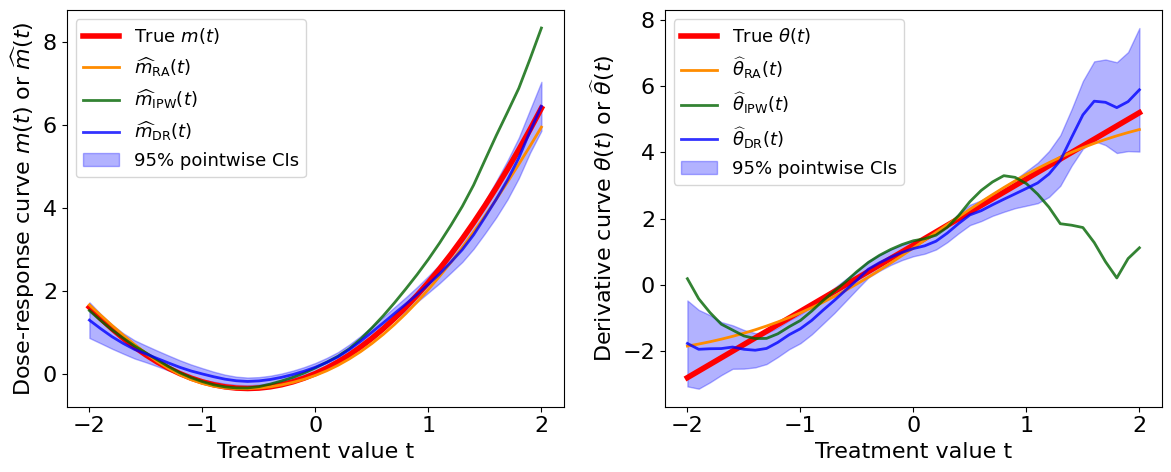

In [9]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(t_qry, 1.2*t_qry + t_qry**2, linewidth=4, color='red', label=r'True $m(t)$')
plt.plot(t_qry, m_est_ra5, linewidth=2, color='darkorange', label=r'$\widehat{m}_{\mathrm{RA}}(t)$')
plt.plot(t_qry, m_est_ipw5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{m}_{\mathrm{IPW}}(t)$')
plt.plot(t_qry, m_est_dr5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{m}_{\mathrm{DR}}(t)$')
plt.fill_between(t_qry, m_est_dr5 - sd_est_dr5*scipy.stats.norm.ppf(0.975), 
                 m_est_dr5 + sd_est_dr5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Dose-response curve $m(t)$ or $\widehat{m}(t)$')

plt.subplot(1, 2, 2)
plt.plot(t_qry, 1.2 + 2*t_qry, linewidth=4, color='red', label=r'True $\theta(t)$')
plt.plot(t_qry, theta_ra5, linewidth=2, color='darkorange', label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$')
plt.plot(t_qry, theta_ipw5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{\theta}_{\mathrm{IPW}}(t)$')
plt.plot(t_qry, theta_dr5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$')
plt.fill_between(t_qry, theta_dr5 - theta_sd5*scipy.stats.norm.ppf(0.975), 
                 theta_dr5 + theta_sd5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Derivative curve $\theta(t)$ or $\widehat{\theta}(t)$')

plt.tight_layout()
plt.show()

## Example 4: RA, IPW, DR Estimations of Dose-Response Curve Derivative Without Positivity

We generate i.i.d. data $\{(Y_i, T_i,S_i)\}_{i=1}^n$ with $n=2000$ from the following data-generating model
\begin{align*}
	&Y=T^3 +T^2 + 10S+\epsilon, \quad T= \sin(\pi S) + E, \quad S\sim \mathrm{Uniform}[-1,1] \subset \mathbb{R}, 
\end{align*}
where $E\sim \mathrm{Uniform}[-0.3,0.3]$ is an independent treatment variation and $\epsilon\sim \mathcal{N}(0,1)$ is an independent noise variable. The marginal supports of $T$ and $S$ are $\mathcal{T}=[-1.3, 1.3]$ and $\mathcal{S}=[-1,1]$ respectively, while the joint support of $(T,S)$ only covers a thin band region of the product space $\mathcal{T}\times \mathcal{S}$. The true derivative effect curve is thus given by $\theta(t)=3t^2 + 2t$.

In [10]:
n = 2000

np.random.seed(123)
# Data generating process
X_sim = 2*np.random.rand(n) - 1
T_sim = np.sin(np.pi*X_sim) + np.random.rand(n)*0.6 - 0.3
Y_sim = T_sim**2 + T_sim**3 + 10*X_sim + np.random.normal(loc=0, scale=1, size=n)
X_dat = np.concatenate([T_sim.reshape(-1,1), X_sim.reshape(-1,1)], axis=1)

# Query points 
t_qry = np.linspace(-0.8, 0.8, 41)

# Choice of the bandwidth parameter
h = 2*np.std(T_sim)*n**(-1/5)

In [11]:
# Bias-corrected RA estimator of \theta(t)
theta_C_RA5 = RADRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, mu=NeurNet, L=5, 
                          n_iter=1000, lr=0.01, h_bar=None, kernT_bar="gaussian")

Epoch [1/1000], Loss: 48.1975
Epoch [2/1000], Loss: 23.6179
Epoch [3/1000], Loss: 5.9870
Epoch [4/1000], Loss: 10.3263
Epoch [5/1000], Loss: 5.4552
Epoch [6/1000], Loss: 4.3283
Epoch [7/1000], Loss: 4.8881
Epoch [8/1000], Loss: 3.1760
Epoch [9/1000], Loss: 1.9304
Epoch [10/1000], Loss: 2.5759
Epoch [11/1000], Loss: 1.5787
Epoch [12/1000], Loss: 1.3965
Epoch [13/1000], Loss: 1.5805
Epoch [14/1000], Loss: 1.2631
Epoch [15/1000], Loss: 1.1558
Epoch [16/1000], Loss: 1.2649
Epoch [17/1000], Loss: 1.1536
Epoch [18/1000], Loss: 1.1266
Epoch [19/1000], Loss: 1.1628
Epoch [20/1000], Loss: 1.1280
Epoch [21/1000], Loss: 1.1131
Epoch [22/1000], Loss: 1.1233
Epoch [23/1000], Loss: 1.1102
Epoch [24/1000], Loss: 1.1031
Epoch [25/1000], Loss: 1.1040
Epoch [26/1000], Loss: 1.0988
Epoch [27/1000], Loss: 1.0952
Epoch [28/1000], Loss: 1.0940
Epoch [29/1000], Loss: 1.0914
Epoch [30/1000], Loss: 1.0894
Epoch [31/1000], Loss: 1.0879
Epoch [32/1000], Loss: 1.0861
Epoch [33/1000], Loss: 1.0845
Epoch [34/1000],

Epoch [272/1000], Loss: 1.0093
Epoch [273/1000], Loss: 1.0093
Epoch [274/1000], Loss: 1.0092
Epoch [275/1000], Loss: 1.0092
Epoch [276/1000], Loss: 1.0092
Epoch [277/1000], Loss: 1.0091
Epoch [278/1000], Loss: 1.0091
Epoch [279/1000], Loss: 1.0091
Epoch [280/1000], Loss: 1.0090
Epoch [281/1000], Loss: 1.0090
Epoch [282/1000], Loss: 1.0090
Epoch [283/1000], Loss: 1.0089
Epoch [284/1000], Loss: 1.0089
Epoch [285/1000], Loss: 1.0089
Epoch [286/1000], Loss: 1.0088
Epoch [287/1000], Loss: 1.0088
Epoch [288/1000], Loss: 1.0088
Epoch [289/1000], Loss: 1.0087
Epoch [290/1000], Loss: 1.0087
Epoch [291/1000], Loss: 1.0087
Epoch [292/1000], Loss: 1.0086
Epoch [293/1000], Loss: 1.0086
Epoch [294/1000], Loss: 1.0086
Epoch [295/1000], Loss: 1.0086
Epoch [296/1000], Loss: 1.0085
Epoch [297/1000], Loss: 1.0085
Epoch [298/1000], Loss: 1.0085
Epoch [299/1000], Loss: 1.0084
Epoch [300/1000], Loss: 1.0084
Epoch [301/1000], Loss: 1.0084
Epoch [302/1000], Loss: 1.0084
Epoch [303/1000], Loss: 1.0083
Epoch [3

Epoch [615/1000], Loss: 1.0055
Epoch [616/1000], Loss: 1.0055
Epoch [617/1000], Loss: 1.0055
Epoch [618/1000], Loss: 1.0055
Epoch [619/1000], Loss: 1.0055
Epoch [620/1000], Loss: 1.0055
Epoch [621/1000], Loss: 1.0055
Epoch [622/1000], Loss: 1.0055
Epoch [623/1000], Loss: 1.0055
Epoch [624/1000], Loss: 1.0055
Epoch [625/1000], Loss: 1.0055
Epoch [626/1000], Loss: 1.0055
Epoch [627/1000], Loss: 1.0055
Epoch [628/1000], Loss: 1.0055
Epoch [629/1000], Loss: 1.0055
Epoch [630/1000], Loss: 1.0055
Epoch [631/1000], Loss: 1.0055
Epoch [632/1000], Loss: 1.0054
Epoch [633/1000], Loss: 1.0054
Epoch [634/1000], Loss: 1.0054
Epoch [635/1000], Loss: 1.0054
Epoch [636/1000], Loss: 1.0054
Epoch [637/1000], Loss: 1.0054
Epoch [638/1000], Loss: 1.0054
Epoch [639/1000], Loss: 1.0054
Epoch [640/1000], Loss: 1.0054
Epoch [641/1000], Loss: 1.0054
Epoch [642/1000], Loss: 1.0054
Epoch [643/1000], Loss: 1.0054
Epoch [644/1000], Loss: 1.0054
Epoch [645/1000], Loss: 1.0054
Epoch [646/1000], Loss: 1.0054
Epoch [6

Epoch [965/1000], Loss: 1.0048
Epoch [966/1000], Loss: 1.0048
Epoch [967/1000], Loss: 1.0048
Epoch [968/1000], Loss: 1.0048
Epoch [969/1000], Loss: 1.0048
Epoch [970/1000], Loss: 1.0048
Epoch [971/1000], Loss: 1.0048
Epoch [972/1000], Loss: 1.0048
Epoch [973/1000], Loss: 1.0048
Epoch [974/1000], Loss: 1.0048
Epoch [975/1000], Loss: 1.0048
Epoch [976/1000], Loss: 1.0048
Epoch [977/1000], Loss: 1.0048
Epoch [978/1000], Loss: 1.0048
Epoch [979/1000], Loss: 1.0048
Epoch [980/1000], Loss: 1.0048
Epoch [981/1000], Loss: 1.0048
Epoch [982/1000], Loss: 1.0048
Epoch [983/1000], Loss: 1.0048
Epoch [984/1000], Loss: 1.0048
Epoch [985/1000], Loss: 1.0048
Epoch [986/1000], Loss: 1.0048
Epoch [987/1000], Loss: 1.0048
Epoch [988/1000], Loss: 1.0048
Epoch [989/1000], Loss: 1.0048
Epoch [990/1000], Loss: 1.0048
Epoch [991/1000], Loss: 1.0048
Epoch [992/1000], Loss: 1.0048
Epoch [993/1000], Loss: 1.0048
Epoch [994/1000], Loss: 1.0048
Epoch [995/1000], Loss: 1.0048
Epoch [996/1000], Loss: 1.0048
Epoch [9

Epoch [271/1000], Loss: 0.9952
Epoch [272/1000], Loss: 0.9952
Epoch [273/1000], Loss: 0.9952
Epoch [274/1000], Loss: 0.9952
Epoch [275/1000], Loss: 0.9951
Epoch [276/1000], Loss: 0.9951
Epoch [277/1000], Loss: 0.9951
Epoch [278/1000], Loss: 0.9951
Epoch [279/1000], Loss: 0.9951
Epoch [280/1000], Loss: 0.9950
Epoch [281/1000], Loss: 0.9950
Epoch [282/1000], Loss: 0.9950
Epoch [283/1000], Loss: 0.9950
Epoch [284/1000], Loss: 0.9949
Epoch [285/1000], Loss: 0.9949
Epoch [286/1000], Loss: 0.9949
Epoch [287/1000], Loss: 0.9949
Epoch [288/1000], Loss: 0.9949
Epoch [289/1000], Loss: 0.9948
Epoch [290/1000], Loss: 0.9948
Epoch [291/1000], Loss: 0.9948
Epoch [292/1000], Loss: 0.9948
Epoch [293/1000], Loss: 0.9948
Epoch [294/1000], Loss: 0.9947
Epoch [295/1000], Loss: 0.9947
Epoch [296/1000], Loss: 0.9947
Epoch [297/1000], Loss: 0.9947
Epoch [298/1000], Loss: 0.9947
Epoch [299/1000], Loss: 0.9946
Epoch [300/1000], Loss: 0.9946
Epoch [301/1000], Loss: 0.9946
Epoch [302/1000], Loss: 0.9946
Epoch [3

Epoch [616/1000], Loss: 0.9917
Epoch [617/1000], Loss: 0.9917
Epoch [618/1000], Loss: 0.9917
Epoch [619/1000], Loss: 0.9917
Epoch [620/1000], Loss: 0.9917
Epoch [621/1000], Loss: 0.9917
Epoch [622/1000], Loss: 0.9917
Epoch [623/1000], Loss: 0.9917
Epoch [624/1000], Loss: 0.9917
Epoch [625/1000], Loss: 0.9916
Epoch [626/1000], Loss: 0.9916
Epoch [627/1000], Loss: 0.9916
Epoch [628/1000], Loss: 0.9916
Epoch [629/1000], Loss: 0.9916
Epoch [630/1000], Loss: 0.9916
Epoch [631/1000], Loss: 0.9916
Epoch [632/1000], Loss: 0.9916
Epoch [633/1000], Loss: 0.9916
Epoch [634/1000], Loss: 0.9916
Epoch [635/1000], Loss: 0.9916
Epoch [636/1000], Loss: 0.9916
Epoch [637/1000], Loss: 0.9916
Epoch [638/1000], Loss: 0.9916
Epoch [639/1000], Loss: 0.9916
Epoch [640/1000], Loss: 0.9916
Epoch [641/1000], Loss: 0.9916
Epoch [642/1000], Loss: 0.9916
Epoch [643/1000], Loss: 0.9916
Epoch [644/1000], Loss: 0.9916
Epoch [645/1000], Loss: 0.9916
Epoch [646/1000], Loss: 0.9916
Epoch [647/1000], Loss: 0.9916
Epoch [6

Epoch [941/1000], Loss: 0.9910
Epoch [942/1000], Loss: 0.9910
Epoch [943/1000], Loss: 0.9910
Epoch [944/1000], Loss: 0.9910
Epoch [945/1000], Loss: 0.9910
Epoch [946/1000], Loss: 0.9910
Epoch [947/1000], Loss: 0.9910
Epoch [948/1000], Loss: 0.9910
Epoch [949/1000], Loss: 0.9910
Epoch [950/1000], Loss: 0.9910
Epoch [951/1000], Loss: 0.9910
Epoch [952/1000], Loss: 0.9910
Epoch [953/1000], Loss: 0.9910
Epoch [954/1000], Loss: 0.9909
Epoch [955/1000], Loss: 0.9909
Epoch [956/1000], Loss: 0.9909
Epoch [957/1000], Loss: 0.9909
Epoch [958/1000], Loss: 0.9909
Epoch [959/1000], Loss: 0.9909
Epoch [960/1000], Loss: 0.9909
Epoch [961/1000], Loss: 0.9909
Epoch [962/1000], Loss: 0.9909
Epoch [963/1000], Loss: 0.9909
Epoch [964/1000], Loss: 0.9909
Epoch [965/1000], Loss: 0.9909
Epoch [966/1000], Loss: 0.9909
Epoch [967/1000], Loss: 0.9909
Epoch [968/1000], Loss: 0.9909
Epoch [969/1000], Loss: 0.9909
Epoch [970/1000], Loss: 0.9909
Epoch [971/1000], Loss: 0.9909
Epoch [972/1000], Loss: 0.9909
Epoch [9

Epoch [238/1000], Loss: 0.9720
Epoch [239/1000], Loss: 0.9719
Epoch [240/1000], Loss: 0.9719
Epoch [241/1000], Loss: 0.9719
Epoch [242/1000], Loss: 0.9718
Epoch [243/1000], Loss: 0.9718
Epoch [244/1000], Loss: 0.9718
Epoch [245/1000], Loss: 0.9717
Epoch [246/1000], Loss: 0.9717
Epoch [247/1000], Loss: 0.9717
Epoch [248/1000], Loss: 0.9716
Epoch [249/1000], Loss: 0.9716
Epoch [250/1000], Loss: 0.9716
Epoch [251/1000], Loss: 0.9715
Epoch [252/1000], Loss: 0.9715
Epoch [253/1000], Loss: 0.9715
Epoch [254/1000], Loss: 0.9714
Epoch [255/1000], Loss: 0.9714
Epoch [256/1000], Loss: 0.9714
Epoch [257/1000], Loss: 0.9713
Epoch [258/1000], Loss: 0.9713
Epoch [259/1000], Loss: 0.9713
Epoch [260/1000], Loss: 0.9713
Epoch [261/1000], Loss: 0.9712
Epoch [262/1000], Loss: 0.9712
Epoch [263/1000], Loss: 0.9712
Epoch [264/1000], Loss: 0.9711
Epoch [265/1000], Loss: 0.9711
Epoch [266/1000], Loss: 0.9711
Epoch [267/1000], Loss: 0.9711
Epoch [268/1000], Loss: 0.9710
Epoch [269/1000], Loss: 0.9710
Epoch [2

Epoch [527/1000], Loss: 0.9675
Epoch [528/1000], Loss: 0.9674
Epoch [529/1000], Loss: 0.9674
Epoch [530/1000], Loss: 0.9674
Epoch [531/1000], Loss: 0.9674
Epoch [532/1000], Loss: 0.9674
Epoch [533/1000], Loss: 0.9674
Epoch [534/1000], Loss: 0.9674
Epoch [535/1000], Loss: 0.9674
Epoch [536/1000], Loss: 0.9674
Epoch [537/1000], Loss: 0.9674
Epoch [538/1000], Loss: 0.9674
Epoch [539/1000], Loss: 0.9674
Epoch [540/1000], Loss: 0.9674
Epoch [541/1000], Loss: 0.9674
Epoch [542/1000], Loss: 0.9674
Epoch [543/1000], Loss: 0.9673
Epoch [544/1000], Loss: 0.9673
Epoch [545/1000], Loss: 0.9673
Epoch [546/1000], Loss: 0.9673
Epoch [547/1000], Loss: 0.9673
Epoch [548/1000], Loss: 0.9673
Epoch [549/1000], Loss: 0.9673
Epoch [550/1000], Loss: 0.9673
Epoch [551/1000], Loss: 0.9673
Epoch [552/1000], Loss: 0.9673
Epoch [553/1000], Loss: 0.9673
Epoch [554/1000], Loss: 0.9673
Epoch [555/1000], Loss: 0.9673
Epoch [556/1000], Loss: 0.9673
Epoch [557/1000], Loss: 0.9673
Epoch [558/1000], Loss: 0.9673
Epoch [5

Epoch [805/1000], Loss: 0.9663
Epoch [806/1000], Loss: 0.9663
Epoch [807/1000], Loss: 0.9662
Epoch [808/1000], Loss: 0.9662
Epoch [809/1000], Loss: 0.9662
Epoch [810/1000], Loss: 0.9662
Epoch [811/1000], Loss: 0.9662
Epoch [812/1000], Loss: 0.9662
Epoch [813/1000], Loss: 0.9662
Epoch [814/1000], Loss: 0.9662
Epoch [815/1000], Loss: 0.9662
Epoch [816/1000], Loss: 0.9662
Epoch [817/1000], Loss: 0.9662
Epoch [818/1000], Loss: 0.9662
Epoch [819/1000], Loss: 0.9662
Epoch [820/1000], Loss: 0.9662
Epoch [821/1000], Loss: 0.9662
Epoch [822/1000], Loss: 0.9662
Epoch [823/1000], Loss: 0.9662
Epoch [824/1000], Loss: 0.9662
Epoch [825/1000], Loss: 0.9662
Epoch [826/1000], Loss: 0.9662
Epoch [827/1000], Loss: 0.9662
Epoch [828/1000], Loss: 0.9662
Epoch [829/1000], Loss: 0.9662
Epoch [830/1000], Loss: 0.9662
Epoch [831/1000], Loss: 0.9662
Epoch [832/1000], Loss: 0.9662
Epoch [833/1000], Loss: 0.9662
Epoch [834/1000], Loss: 0.9662
Epoch [835/1000], Loss: 0.9662
Epoch [836/1000], Loss: 0.9662
Epoch [8

Epoch [86/1000], Loss: 0.9729
Epoch [87/1000], Loss: 0.9725
Epoch [88/1000], Loss: 0.9722
Epoch [89/1000], Loss: 0.9720
Epoch [90/1000], Loss: 0.9717
Epoch [91/1000], Loss: 0.9714
Epoch [92/1000], Loss: 0.9711
Epoch [93/1000], Loss: 0.9708
Epoch [94/1000], Loss: 0.9706
Epoch [95/1000], Loss: 0.9703
Epoch [96/1000], Loss: 0.9700
Epoch [97/1000], Loss: 0.9698
Epoch [98/1000], Loss: 0.9695
Epoch [99/1000], Loss: 0.9693
Epoch [100/1000], Loss: 0.9690
Epoch [101/1000], Loss: 0.9688
Epoch [102/1000], Loss: 0.9686
Epoch [103/1000], Loss: 0.9684
Epoch [104/1000], Loss: 0.9681
Epoch [105/1000], Loss: 0.9679
Epoch [106/1000], Loss: 0.9677
Epoch [107/1000], Loss: 0.9675
Epoch [108/1000], Loss: 0.9673
Epoch [109/1000], Loss: 0.9671
Epoch [110/1000], Loss: 0.9669
Epoch [111/1000], Loss: 0.9667
Epoch [112/1000], Loss: 0.9665
Epoch [113/1000], Loss: 0.9663
Epoch [114/1000], Loss: 0.9661
Epoch [115/1000], Loss: 0.9659
Epoch [116/1000], Loss: 0.9657
Epoch [117/1000], Loss: 0.9656
Epoch [118/1000], Loss

Epoch [430/1000], Loss: 0.9547
Epoch [431/1000], Loss: 0.9547
Epoch [432/1000], Loss: 0.9547
Epoch [433/1000], Loss: 0.9547
Epoch [434/1000], Loss: 0.9547
Epoch [435/1000], Loss: 0.9547
Epoch [436/1000], Loss: 0.9547
Epoch [437/1000], Loss: 0.9547
Epoch [438/1000], Loss: 0.9547
Epoch [439/1000], Loss: 0.9547
Epoch [440/1000], Loss: 0.9547
Epoch [441/1000], Loss: 0.9546
Epoch [442/1000], Loss: 0.9546
Epoch [443/1000], Loss: 0.9546
Epoch [444/1000], Loss: 0.9546
Epoch [445/1000], Loss: 0.9546
Epoch [446/1000], Loss: 0.9546
Epoch [447/1000], Loss: 0.9546
Epoch [448/1000], Loss: 0.9546
Epoch [449/1000], Loss: 0.9546
Epoch [450/1000], Loss: 0.9546
Epoch [451/1000], Loss: 0.9546
Epoch [452/1000], Loss: 0.9546
Epoch [453/1000], Loss: 0.9546
Epoch [454/1000], Loss: 0.9546
Epoch [455/1000], Loss: 0.9546
Epoch [456/1000], Loss: 0.9546
Epoch [457/1000], Loss: 0.9546
Epoch [458/1000], Loss: 0.9546
Epoch [459/1000], Loss: 0.9546
Epoch [460/1000], Loss: 0.9546
Epoch [461/1000], Loss: 0.9546
Epoch [4

Epoch [706/1000], Loss: 0.9539
Epoch [707/1000], Loss: 0.9539
Epoch [708/1000], Loss: 0.9539
Epoch [709/1000], Loss: 0.9539
Epoch [710/1000], Loss: 0.9539
Epoch [711/1000], Loss: 0.9539
Epoch [712/1000], Loss: 0.9539
Epoch [713/1000], Loss: 0.9539
Epoch [714/1000], Loss: 0.9539
Epoch [715/1000], Loss: 0.9539
Epoch [716/1000], Loss: 0.9539
Epoch [717/1000], Loss: 0.9539
Epoch [718/1000], Loss: 0.9539
Epoch [719/1000], Loss: 0.9539
Epoch [720/1000], Loss: 0.9539
Epoch [721/1000], Loss: 0.9539
Epoch [722/1000], Loss: 0.9539
Epoch [723/1000], Loss: 0.9539
Epoch [724/1000], Loss: 0.9538
Epoch [725/1000], Loss: 0.9538
Epoch [726/1000], Loss: 0.9538
Epoch [727/1000], Loss: 0.9538
Epoch [728/1000], Loss: 0.9538
Epoch [729/1000], Loss: 0.9538
Epoch [730/1000], Loss: 0.9538
Epoch [731/1000], Loss: 0.9538
Epoch [732/1000], Loss: 0.9538
Epoch [733/1000], Loss: 0.9538
Epoch [734/1000], Loss: 0.9538
Epoch [735/1000], Loss: 0.9538
Epoch [736/1000], Loss: 0.9538
Epoch [737/1000], Loss: 0.9538
Epoch [7

Epoch [974/1000], Loss: 0.9534
Epoch [975/1000], Loss: 0.9534
Epoch [976/1000], Loss: 0.9534
Epoch [977/1000], Loss: 0.9534
Epoch [978/1000], Loss: 0.9534
Epoch [979/1000], Loss: 0.9534
Epoch [980/1000], Loss: 0.9534
Epoch [981/1000], Loss: 0.9534
Epoch [982/1000], Loss: 0.9534
Epoch [983/1000], Loss: 0.9534
Epoch [984/1000], Loss: 0.9534
Epoch [985/1000], Loss: 0.9534
Epoch [986/1000], Loss: 0.9534
Epoch [987/1000], Loss: 0.9534
Epoch [988/1000], Loss: 0.9534
Epoch [989/1000], Loss: 0.9534
Epoch [990/1000], Loss: 0.9534
Epoch [991/1000], Loss: 0.9534
Epoch [992/1000], Loss: 0.9534
Epoch [993/1000], Loss: 0.9534
Epoch [994/1000], Loss: 0.9534
Epoch [995/1000], Loss: 0.9534
Epoch [996/1000], Loss: 0.9534
Epoch [997/1000], Loss: 0.9534
Epoch [998/1000], Loss: 0.9534
Epoch [999/1000], Loss: 0.9534
Epoch [1000/1000], Loss: 0.9534
Epoch [1/1000], Loss: 39.9167
Epoch [2/1000], Loss: 27.4716
Epoch [3/1000], Loss: 14.3710
Epoch [4/1000], Loss: 9.3550
Epoch [5/1000], Loss: 5.8485
Epoch [6/1000]

Epoch [258/1000], Loss: 0.9871
Epoch [259/1000], Loss: 0.9870
Epoch [260/1000], Loss: 0.9870
Epoch [261/1000], Loss: 0.9869
Epoch [262/1000], Loss: 0.9869
Epoch [263/1000], Loss: 0.9868
Epoch [264/1000], Loss: 0.9868
Epoch [265/1000], Loss: 0.9867
Epoch [266/1000], Loss: 0.9867
Epoch [267/1000], Loss: 0.9867
Epoch [268/1000], Loss: 0.9866
Epoch [269/1000], Loss: 0.9866
Epoch [270/1000], Loss: 0.9865
Epoch [271/1000], Loss: 0.9865
Epoch [272/1000], Loss: 0.9864
Epoch [273/1000], Loss: 0.9864
Epoch [274/1000], Loss: 0.9863
Epoch [275/1000], Loss: 0.9863
Epoch [276/1000], Loss: 0.9862
Epoch [277/1000], Loss: 0.9862
Epoch [278/1000], Loss: 0.9862
Epoch [279/1000], Loss: 0.9861
Epoch [280/1000], Loss: 0.9861
Epoch [281/1000], Loss: 0.9860
Epoch [282/1000], Loss: 0.9860
Epoch [283/1000], Loss: 0.9859
Epoch [284/1000], Loss: 0.9859
Epoch [285/1000], Loss: 0.9859
Epoch [286/1000], Loss: 0.9858
Epoch [287/1000], Loss: 0.9858
Epoch [288/1000], Loss: 0.9857
Epoch [289/1000], Loss: 0.9857
Epoch [2

Epoch [607/1000], Loss: 0.9793
Epoch [608/1000], Loss: 0.9793
Epoch [609/1000], Loss: 0.9793
Epoch [610/1000], Loss: 0.9792
Epoch [611/1000], Loss: 0.9792
Epoch [612/1000], Loss: 0.9792
Epoch [613/1000], Loss: 0.9792
Epoch [614/1000], Loss: 0.9792
Epoch [615/1000], Loss: 0.9792
Epoch [616/1000], Loss: 0.9792
Epoch [617/1000], Loss: 0.9792
Epoch [618/1000], Loss: 0.9792
Epoch [619/1000], Loss: 0.9792
Epoch [620/1000], Loss: 0.9792
Epoch [621/1000], Loss: 0.9791
Epoch [622/1000], Loss: 0.9791
Epoch [623/1000], Loss: 0.9791
Epoch [624/1000], Loss: 0.9791
Epoch [625/1000], Loss: 0.9791
Epoch [626/1000], Loss: 0.9791
Epoch [627/1000], Loss: 0.9791
Epoch [628/1000], Loss: 0.9791
Epoch [629/1000], Loss: 0.9791
Epoch [630/1000], Loss: 0.9791
Epoch [631/1000], Loss: 0.9791
Epoch [632/1000], Loss: 0.9790
Epoch [633/1000], Loss: 0.9790
Epoch [634/1000], Loss: 0.9790
Epoch [635/1000], Loss: 0.9790
Epoch [636/1000], Loss: 0.9790
Epoch [637/1000], Loss: 0.9790
Epoch [638/1000], Loss: 0.9790
Epoch [6

Epoch [875/1000], Loss: 0.9777
Epoch [876/1000], Loss: 0.9777
Epoch [877/1000], Loss: 0.9777
Epoch [878/1000], Loss: 0.9777
Epoch [879/1000], Loss: 0.9777
Epoch [880/1000], Loss: 0.9777
Epoch [881/1000], Loss: 0.9777
Epoch [882/1000], Loss: 0.9777
Epoch [883/1000], Loss: 0.9777
Epoch [884/1000], Loss: 0.9777
Epoch [885/1000], Loss: 0.9777
Epoch [886/1000], Loss: 0.9777
Epoch [887/1000], Loss: 0.9777
Epoch [888/1000], Loss: 0.9777
Epoch [889/1000], Loss: 0.9777
Epoch [890/1000], Loss: 0.9777
Epoch [891/1000], Loss: 0.9777
Epoch [892/1000], Loss: 0.9777
Epoch [893/1000], Loss: 0.9777
Epoch [894/1000], Loss: 0.9777
Epoch [895/1000], Loss: 0.9777
Epoch [896/1000], Loss: 0.9777
Epoch [897/1000], Loss: 0.9777
Epoch [898/1000], Loss: 0.9777
Epoch [899/1000], Loss: 0.9777
Epoch [900/1000], Loss: 0.9777
Epoch [901/1000], Loss: 0.9777
Epoch [902/1000], Loss: 0.9777
Epoch [903/1000], Loss: 0.9777
Epoch [904/1000], Loss: 0.9776
Epoch [905/1000], Loss: 0.9776
Epoch [906/1000], Loss: 0.9776
Epoch [9

In [12]:
# Bias-corrected IPW estimator of \theta(t)
theta_C_IPW5, condTS5 = IPWDRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, L=5, h=h, kern='epanechnikov', 
                                     b=None, self_norm=True, thres_val=0.85)

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.17244756].

The current bandwidth is [0.17836962].

The current bandwidth is [0.21534616 0.

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].

The current bandwidth is [0.17767765].

The current bandwidth is [0.21451074 0.17112705].


The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].


In [13]:
# Bias-corrected DR estimator of \theta(t)
theta_C_DR5, theta_C_sd5 = DRDRDerivBC(Y=Y_sim, X=X_dat, t_eval=t_qry, mu=NeurNet, L=5, h=h, kern='epanechnikov', 
                                       n_iter=1000, lr=0.01, b=None, thres_val=0.85, self_norm=False)

The current bandwidth is [0.21534616 0.17244756].

Epoch [1/1000], Loss: 41.2835
Epoch [2/1000], Loss: 25.8008
Epoch [3/1000], Loss: 8.9370
Epoch [4/1000], Loss: 8.6474
Epoch [5/1000], Loss: 7.2775
Epoch [6/1000], Loss: 4.4600
Epoch [7/1000], Loss: 5.4696
Epoch [8/1000], Loss: 3.1059
Epoch [9/1000], Loss: 1.8705
Epoch [10/1000], Loss: 2.7268
Epoch [11/1000], Loss: 1.3913
Epoch [12/1000], Loss: 1.4744
Epoch [13/1000], Loss: 1.5209
Epoch [14/1000], Loss: 1.2307
Epoch [15/1000], Loss: 1.2901
Epoch [16/1000], Loss: 1.2276
Epoch [17/1000], Loss: 1.1823
Epoch [18/1000], Loss: 1.2017
Epoch [19/1000], Loss: 1.1407
Epoch [20/1000], Loss: 1.1356
Epoch [21/1000], Loss: 1.1393
Epoch [22/1000], Loss: 1.1124
Epoch [23/1000], Loss: 1.1132
Epoch [24/1000], Loss: 1.1119
Epoch [25/1000], Loss: 1.1030
Epoch [26/1000], Loss: 1.1021
Epoch [27/1000], Loss: 1.0990
Epoch [28/1000], Loss: 1.0956
Epoch [29/1000], Loss: 1.0939
Epoch [30/1000], Loss: 1.0910
Epoch [31/1000], Loss: 1.0890
Epoch [32/1000], Loss: 1.0

Epoch [287/1000], Loss: 1.0077
Epoch [288/1000], Loss: 1.0077
Epoch [289/1000], Loss: 1.0077
Epoch [290/1000], Loss: 1.0077
Epoch [291/1000], Loss: 1.0076
Epoch [292/1000], Loss: 1.0076
Epoch [293/1000], Loss: 1.0076
Epoch [294/1000], Loss: 1.0076
Epoch [295/1000], Loss: 1.0075
Epoch [296/1000], Loss: 1.0075
Epoch [297/1000], Loss: 1.0075
Epoch [298/1000], Loss: 1.0075
Epoch [299/1000], Loss: 1.0075
Epoch [300/1000], Loss: 1.0074
Epoch [301/1000], Loss: 1.0074
Epoch [302/1000], Loss: 1.0074
Epoch [303/1000], Loss: 1.0074
Epoch [304/1000], Loss: 1.0074
Epoch [305/1000], Loss: 1.0073
Epoch [306/1000], Loss: 1.0073
Epoch [307/1000], Loss: 1.0073
Epoch [308/1000], Loss: 1.0073
Epoch [309/1000], Loss: 1.0073
Epoch [310/1000], Loss: 1.0073
Epoch [311/1000], Loss: 1.0072
Epoch [312/1000], Loss: 1.0072
Epoch [313/1000], Loss: 1.0072
Epoch [314/1000], Loss: 1.0072
Epoch [315/1000], Loss: 1.0072
Epoch [316/1000], Loss: 1.0072
Epoch [317/1000], Loss: 1.0071
Epoch [318/1000], Loss: 1.0071
Epoch [3

Epoch [626/1000], Loss: 1.0056
Epoch [627/1000], Loss: 1.0056
Epoch [628/1000], Loss: 1.0056
Epoch [629/1000], Loss: 1.0056
Epoch [630/1000], Loss: 1.0056
Epoch [631/1000], Loss: 1.0056
Epoch [632/1000], Loss: 1.0056
Epoch [633/1000], Loss: 1.0056
Epoch [634/1000], Loss: 1.0056
Epoch [635/1000], Loss: 1.0056
Epoch [636/1000], Loss: 1.0056
Epoch [637/1000], Loss: 1.0056
Epoch [638/1000], Loss: 1.0056
Epoch [639/1000], Loss: 1.0056
Epoch [640/1000], Loss: 1.0056
Epoch [641/1000], Loss: 1.0056
Epoch [642/1000], Loss: 1.0056
Epoch [643/1000], Loss: 1.0056
Epoch [644/1000], Loss: 1.0056
Epoch [645/1000], Loss: 1.0056
Epoch [646/1000], Loss: 1.0056
Epoch [647/1000], Loss: 1.0056
Epoch [648/1000], Loss: 1.0056
Epoch [649/1000], Loss: 1.0056
Epoch [650/1000], Loss: 1.0056
Epoch [651/1000], Loss: 1.0056
Epoch [652/1000], Loss: 1.0056
Epoch [653/1000], Loss: 1.0056
Epoch [654/1000], Loss: 1.0056
Epoch [655/1000], Loss: 1.0056
Epoch [656/1000], Loss: 1.0056
Epoch [657/1000], Loss: 1.0056
Epoch [6

Epoch [965/1000], Loss: 1.0052
Epoch [966/1000], Loss: 1.0052
Epoch [967/1000], Loss: 1.0052
Epoch [968/1000], Loss: 1.0052
Epoch [969/1000], Loss: 1.0052
Epoch [970/1000], Loss: 1.0052
Epoch [971/1000], Loss: 1.0052
Epoch [972/1000], Loss: 1.0052
Epoch [973/1000], Loss: 1.0052
Epoch [974/1000], Loss: 1.0052
Epoch [975/1000], Loss: 1.0052
Epoch [976/1000], Loss: 1.0052
Epoch [977/1000], Loss: 1.0052
Epoch [978/1000], Loss: 1.0052
Epoch [979/1000], Loss: 1.0052
Epoch [980/1000], Loss: 1.0052
Epoch [981/1000], Loss: 1.0052
Epoch [982/1000], Loss: 1.0052
Epoch [983/1000], Loss: 1.0052
Epoch [984/1000], Loss: 1.0052
Epoch [985/1000], Loss: 1.0052
Epoch [986/1000], Loss: 1.0052
Epoch [987/1000], Loss: 1.0052
Epoch [988/1000], Loss: 1.0052
Epoch [989/1000], Loss: 1.0052
Epoch [990/1000], Loss: 1.0052
Epoch [991/1000], Loss: 1.0052
Epoch [992/1000], Loss: 1.0052
Epoch [993/1000], Loss: 1.0052
Epoch [994/1000], Loss: 1.0052
Epoch [995/1000], Loss: 1.0052
Epoch [996/1000], Loss: 1.0052
Epoch [9

Epoch [189/1000], Loss: 0.9945
Epoch [190/1000], Loss: 0.9944
Epoch [191/1000], Loss: 0.9944
Epoch [192/1000], Loss: 0.9944
Epoch [193/1000], Loss: 0.9944
Epoch [194/1000], Loss: 0.9943
Epoch [195/1000], Loss: 0.9943
Epoch [196/1000], Loss: 0.9943
Epoch [197/1000], Loss: 0.9943
Epoch [198/1000], Loss: 0.9942
Epoch [199/1000], Loss: 0.9942
Epoch [200/1000], Loss: 0.9942
Epoch [201/1000], Loss: 0.9942
Epoch [202/1000], Loss: 0.9941
Epoch [203/1000], Loss: 0.9941
Epoch [204/1000], Loss: 0.9941
Epoch [205/1000], Loss: 0.9941
Epoch [206/1000], Loss: 0.9940
Epoch [207/1000], Loss: 0.9940
Epoch [208/1000], Loss: 0.9940
Epoch [209/1000], Loss: 0.9940
Epoch [210/1000], Loss: 0.9940
Epoch [211/1000], Loss: 0.9939
Epoch [212/1000], Loss: 0.9939
Epoch [213/1000], Loss: 0.9939
Epoch [214/1000], Loss: 0.9939
Epoch [215/1000], Loss: 0.9939
Epoch [216/1000], Loss: 0.9938
Epoch [217/1000], Loss: 0.9938
Epoch [218/1000], Loss: 0.9938
Epoch [219/1000], Loss: 0.9938
Epoch [220/1000], Loss: 0.9938
Epoch [2

Epoch [455/1000], Loss: 0.9924
Epoch [456/1000], Loss: 0.9924
Epoch [457/1000], Loss: 0.9924
Epoch [458/1000], Loss: 0.9924
Epoch [459/1000], Loss: 0.9924
Epoch [460/1000], Loss: 0.9924
Epoch [461/1000], Loss: 0.9924
Epoch [462/1000], Loss: 0.9924
Epoch [463/1000], Loss: 0.9924
Epoch [464/1000], Loss: 0.9924
Epoch [465/1000], Loss: 0.9924
Epoch [466/1000], Loss: 0.9924
Epoch [467/1000], Loss: 0.9924
Epoch [468/1000], Loss: 0.9924
Epoch [469/1000], Loss: 0.9924
Epoch [470/1000], Loss: 0.9924
Epoch [471/1000], Loss: 0.9924
Epoch [472/1000], Loss: 0.9924
Epoch [473/1000], Loss: 0.9924
Epoch [474/1000], Loss: 0.9924
Epoch [475/1000], Loss: 0.9924
Epoch [476/1000], Loss: 0.9924
Epoch [477/1000], Loss: 0.9924
Epoch [478/1000], Loss: 0.9924
Epoch [479/1000], Loss: 0.9924
Epoch [480/1000], Loss: 0.9924
Epoch [481/1000], Loss: 0.9924
Epoch [482/1000], Loss: 0.9924
Epoch [483/1000], Loss: 0.9924
Epoch [484/1000], Loss: 0.9924
Epoch [485/1000], Loss: 0.9924
Epoch [486/1000], Loss: 0.9924
Epoch [4

Epoch [767/1000], Loss: 0.9919
Epoch [768/1000], Loss: 0.9919
Epoch [769/1000], Loss: 0.9919
Epoch [770/1000], Loss: 0.9919
Epoch [771/1000], Loss: 0.9919
Epoch [772/1000], Loss: 0.9919
Epoch [773/1000], Loss: 0.9919
Epoch [774/1000], Loss: 0.9919
Epoch [775/1000], Loss: 0.9919
Epoch [776/1000], Loss: 0.9919
Epoch [777/1000], Loss: 0.9919
Epoch [778/1000], Loss: 0.9919
Epoch [779/1000], Loss: 0.9919
Epoch [780/1000], Loss: 0.9919
Epoch [781/1000], Loss: 0.9919
Epoch [782/1000], Loss: 0.9919
Epoch [783/1000], Loss: 0.9919
Epoch [784/1000], Loss: 0.9919
Epoch [785/1000], Loss: 0.9919
Epoch [786/1000], Loss: 0.9919
Epoch [787/1000], Loss: 0.9919
Epoch [788/1000], Loss: 0.9919
Epoch [789/1000], Loss: 0.9919
Epoch [790/1000], Loss: 0.9919
Epoch [791/1000], Loss: 0.9919
Epoch [792/1000], Loss: 0.9919
Epoch [793/1000], Loss: 0.9919
Epoch [794/1000], Loss: 0.9919
Epoch [795/1000], Loss: 0.9919
Epoch [796/1000], Loss: 0.9919
Epoch [797/1000], Loss: 0.9919
Epoch [798/1000], Loss: 0.9919
Epoch [7

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].

The current bandwidth is [0.17885398].

The current bandwidth is [0.21593094 0.16999861].


Epoch [198/1000], Loss: 0.9748
Epoch [199/1000], Loss: 0.9748
Epoch [200/1000], Loss: 0.9747
Epoch [201/1000], Loss: 0.9746
Epoch [202/1000], Loss: 0.9746
Epoch [203/1000], Loss: 0.9745
Epoch [204/1000], Loss: 0.9745
Epoch [205/1000], Loss: 0.9744
Epoch [206/1000], Loss: 0.9744
Epoch [207/1000], Loss: 0.9743
Epoch [208/1000], Loss: 0.9742
Epoch [209/1000], Loss: 0.9742
Epoch [210/1000], Loss: 0.9741
Epoch [211/1000], Loss: 0.9741
Epoch [212/1000], Loss: 0.9740
Epoch [213/1000], Loss: 0.9740
Epoch [214/1000], Loss: 0.9739
Epoch [215/1000], Loss: 0.9739
Epoch [216/1000], Loss: 0.9738
Epoch [217/1000], Loss: 0.9738
Epoch [218/1000], Loss: 0.9737
Epoch [219/1000], Loss: 0.9737
Epoch [220/1000], Loss: 0.9737
Epoch [221/1000], Loss: 0.9736
Epoch [222/1000], Loss: 0.9736
Epoch [223/1000], Loss: 0.9735
Epoch [224/1000], Loss: 0.9735
Epoch [225/1000], Loss: 0.9734
Epoch [226/1000], Loss: 0.9734
Epoch [227/1000], Loss: 0.9733
Epoch [228/1000], Loss: 0.9733
Epoch [229/1000], Loss: 0.9733
Epoch [2

Epoch [528/1000], Loss: 0.9682
Epoch [529/1000], Loss: 0.9682
Epoch [530/1000], Loss: 0.9682
Epoch [531/1000], Loss: 0.9682
Epoch [532/1000], Loss: 0.9682
Epoch [533/1000], Loss: 0.9682
Epoch [534/1000], Loss: 0.9682
Epoch [535/1000], Loss: 0.9682
Epoch [536/1000], Loss: 0.9682
Epoch [537/1000], Loss: 0.9682
Epoch [538/1000], Loss: 0.9682
Epoch [539/1000], Loss: 0.9682
Epoch [540/1000], Loss: 0.9682
Epoch [541/1000], Loss: 0.9681
Epoch [542/1000], Loss: 0.9681
Epoch [543/1000], Loss: 0.9681
Epoch [544/1000], Loss: 0.9681
Epoch [545/1000], Loss: 0.9681
Epoch [546/1000], Loss: 0.9681
Epoch [547/1000], Loss: 0.9681
Epoch [548/1000], Loss: 0.9681
Epoch [549/1000], Loss: 0.9681
Epoch [550/1000], Loss: 0.9681
Epoch [551/1000], Loss: 0.9681
Epoch [552/1000], Loss: 0.9681
Epoch [553/1000], Loss: 0.9681
Epoch [554/1000], Loss: 0.9680
Epoch [555/1000], Loss: 0.9680
Epoch [556/1000], Loss: 0.9680
Epoch [557/1000], Loss: 0.9680
Epoch [558/1000], Loss: 0.9680
Epoch [559/1000], Loss: 0.9680
Epoch [5

Epoch [871/1000], Loss: 0.9666
Epoch [872/1000], Loss: 0.9666
Epoch [873/1000], Loss: 0.9666
Epoch [874/1000], Loss: 0.9666
Epoch [875/1000], Loss: 0.9666
Epoch [876/1000], Loss: 0.9666
Epoch [877/1000], Loss: 0.9666
Epoch [878/1000], Loss: 0.9666
Epoch [879/1000], Loss: 0.9666
Epoch [880/1000], Loss: 0.9666
Epoch [881/1000], Loss: 0.9666
Epoch [882/1000], Loss: 0.9666
Epoch [883/1000], Loss: 0.9666
Epoch [884/1000], Loss: 0.9666
Epoch [885/1000], Loss: 0.9666
Epoch [886/1000], Loss: 0.9665
Epoch [887/1000], Loss: 0.9665
Epoch [888/1000], Loss: 0.9665
Epoch [889/1000], Loss: 0.9665
Epoch [890/1000], Loss: 0.9665
Epoch [891/1000], Loss: 0.9665
Epoch [892/1000], Loss: 0.9665
Epoch [893/1000], Loss: 0.9665
Epoch [894/1000], Loss: 0.9665
Epoch [895/1000], Loss: 0.9665
Epoch [896/1000], Loss: 0.9665
Epoch [897/1000], Loss: 0.9665
Epoch [898/1000], Loss: 0.9665
Epoch [899/1000], Loss: 0.9665
Epoch [900/1000], Loss: 0.9665
Epoch [901/1000], Loss: 0.9665
Epoch [902/1000], Loss: 0.9665
Epoch [9

Epoch [69/1000], Loss: 0.9770
Epoch [70/1000], Loss: 0.9766
Epoch [71/1000], Loss: 0.9762
Epoch [72/1000], Loss: 0.9757
Epoch [73/1000], Loss: 0.9754
Epoch [74/1000], Loss: 0.9750
Epoch [75/1000], Loss: 0.9746
Epoch [76/1000], Loss: 0.9742
Epoch [77/1000], Loss: 0.9738
Epoch [78/1000], Loss: 0.9735
Epoch [79/1000], Loss: 0.9731
Epoch [80/1000], Loss: 0.9728
Epoch [81/1000], Loss: 0.9725
Epoch [82/1000], Loss: 0.9721
Epoch [83/1000], Loss: 0.9718
Epoch [84/1000], Loss: 0.9715
Epoch [85/1000], Loss: 0.9712
Epoch [86/1000], Loss: 0.9709
Epoch [87/1000], Loss: 0.9706
Epoch [88/1000], Loss: 0.9703
Epoch [89/1000], Loss: 0.9700
Epoch [90/1000], Loss: 0.9697
Epoch [91/1000], Loss: 0.9695
Epoch [92/1000], Loss: 0.9692
Epoch [93/1000], Loss: 0.9689
Epoch [94/1000], Loss: 0.9687
Epoch [95/1000], Loss: 0.9684
Epoch [96/1000], Loss: 0.9682
Epoch [97/1000], Loss: 0.9679
Epoch [98/1000], Loss: 0.9677
Epoch [99/1000], Loss: 0.9675
Epoch [100/1000], Loss: 0.9672
Epoch [101/1000], Loss: 0.9670
Epoch [1

Epoch [335/1000], Loss: 0.9550
Epoch [336/1000], Loss: 0.9550
Epoch [337/1000], Loss: 0.9550
Epoch [338/1000], Loss: 0.9550
Epoch [339/1000], Loss: 0.9550
Epoch [340/1000], Loss: 0.9550
Epoch [341/1000], Loss: 0.9550
Epoch [342/1000], Loss: 0.9550
Epoch [343/1000], Loss: 0.9550
Epoch [344/1000], Loss: 0.9549
Epoch [345/1000], Loss: 0.9549
Epoch [346/1000], Loss: 0.9549
Epoch [347/1000], Loss: 0.9549
Epoch [348/1000], Loss: 0.9549
Epoch [349/1000], Loss: 0.9549
Epoch [350/1000], Loss: 0.9549
Epoch [351/1000], Loss: 0.9549
Epoch [352/1000], Loss: 0.9549
Epoch [353/1000], Loss: 0.9549
Epoch [354/1000], Loss: 0.9549
Epoch [355/1000], Loss: 0.9549
Epoch [356/1000], Loss: 0.9548
Epoch [357/1000], Loss: 0.9548
Epoch [358/1000], Loss: 0.9548
Epoch [359/1000], Loss: 0.9548
Epoch [360/1000], Loss: 0.9548
Epoch [361/1000], Loss: 0.9548
Epoch [362/1000], Loss: 0.9548
Epoch [363/1000], Loss: 0.9548
Epoch [364/1000], Loss: 0.9548
Epoch [365/1000], Loss: 0.9548
Epoch [366/1000], Loss: 0.9548
Epoch [3

Epoch [610/1000], Loss: 0.9537
Epoch [611/1000], Loss: 0.9537
Epoch [612/1000], Loss: 0.9537
Epoch [613/1000], Loss: 0.9537
Epoch [614/1000], Loss: 0.9537
Epoch [615/1000], Loss: 0.9537
Epoch [616/1000], Loss: 0.9537
Epoch [617/1000], Loss: 0.9537
Epoch [618/1000], Loss: 0.9537
Epoch [619/1000], Loss: 0.9537
Epoch [620/1000], Loss: 0.9537
Epoch [621/1000], Loss: 0.9537
Epoch [622/1000], Loss: 0.9537
Epoch [623/1000], Loss: 0.9537
Epoch [624/1000], Loss: 0.9537
Epoch [625/1000], Loss: 0.9537
Epoch [626/1000], Loss: 0.9536
Epoch [627/1000], Loss: 0.9536
Epoch [628/1000], Loss: 0.9536
Epoch [629/1000], Loss: 0.9536
Epoch [630/1000], Loss: 0.9536
Epoch [631/1000], Loss: 0.9536
Epoch [632/1000], Loss: 0.9536
Epoch [633/1000], Loss: 0.9536
Epoch [634/1000], Loss: 0.9536
Epoch [635/1000], Loss: 0.9536
Epoch [636/1000], Loss: 0.9536
Epoch [637/1000], Loss: 0.9536
Epoch [638/1000], Loss: 0.9536
Epoch [639/1000], Loss: 0.9536
Epoch [640/1000], Loss: 0.9536
Epoch [641/1000], Loss: 0.9536
Epoch [6

Epoch [882/1000], Loss: 0.9532
Epoch [883/1000], Loss: 0.9532
Epoch [884/1000], Loss: 0.9532
Epoch [885/1000], Loss: 0.9532
Epoch [886/1000], Loss: 0.9532
Epoch [887/1000], Loss: 0.9532
Epoch [888/1000], Loss: 0.9532
Epoch [889/1000], Loss: 0.9532
Epoch [890/1000], Loss: 0.9532
Epoch [891/1000], Loss: 0.9532
Epoch [892/1000], Loss: 0.9532
Epoch [893/1000], Loss: 0.9532
Epoch [894/1000], Loss: 0.9532
Epoch [895/1000], Loss: 0.9532
Epoch [896/1000], Loss: 0.9532
Epoch [897/1000], Loss: 0.9532
Epoch [898/1000], Loss: 0.9532
Epoch [899/1000], Loss: 0.9532
Epoch [900/1000], Loss: 0.9532
Epoch [901/1000], Loss: 0.9532
Epoch [902/1000], Loss: 0.9532
Epoch [903/1000], Loss: 0.9532
Epoch [904/1000], Loss: 0.9532
Epoch [905/1000], Loss: 0.9532
Epoch [906/1000], Loss: 0.9532
Epoch [907/1000], Loss: 0.9532
Epoch [908/1000], Loss: 0.9531
Epoch [909/1000], Loss: 0.9531
Epoch [910/1000], Loss: 0.9531
Epoch [911/1000], Loss: 0.9531
Epoch [912/1000], Loss: 0.9531
Epoch [913/1000], Loss: 0.9531
Epoch [9

Epoch [62/1000], Loss: 1.0212
Epoch [63/1000], Loss: 1.0203
Epoch [64/1000], Loss: 1.0196
Epoch [65/1000], Loss: 1.0188
Epoch [66/1000], Loss: 1.0181
Epoch [67/1000], Loss: 1.0173
Epoch [68/1000], Loss: 1.0166
Epoch [69/1000], Loss: 1.0160
Epoch [70/1000], Loss: 1.0153
Epoch [71/1000], Loss: 1.0146
Epoch [72/1000], Loss: 1.0140
Epoch [73/1000], Loss: 1.0134
Epoch [74/1000], Loss: 1.0128
Epoch [75/1000], Loss: 1.0122
Epoch [76/1000], Loss: 1.0116
Epoch [77/1000], Loss: 1.0111
Epoch [78/1000], Loss: 1.0105
Epoch [79/1000], Loss: 1.0100
Epoch [80/1000], Loss: 1.0095
Epoch [81/1000], Loss: 1.0090
Epoch [82/1000], Loss: 1.0085
Epoch [83/1000], Loss: 1.0080
Epoch [84/1000], Loss: 1.0075
Epoch [85/1000], Loss: 1.0071
Epoch [86/1000], Loss: 1.0066
Epoch [87/1000], Loss: 1.0062
Epoch [88/1000], Loss: 1.0057
Epoch [89/1000], Loss: 1.0053
Epoch [90/1000], Loss: 1.0049
Epoch [91/1000], Loss: 1.0045
Epoch [92/1000], Loss: 1.0041
Epoch [93/1000], Loss: 1.0037
Epoch [94/1000], Loss: 1.0033
Epoch [95/

Epoch [398/1000], Loss: 0.9793
Epoch [399/1000], Loss: 0.9793
Epoch [400/1000], Loss: 0.9793
Epoch [401/1000], Loss: 0.9792
Epoch [402/1000], Loss: 0.9792
Epoch [403/1000], Loss: 0.9792
Epoch [404/1000], Loss: 0.9792
Epoch [405/1000], Loss: 0.9792
Epoch [406/1000], Loss: 0.9792
Epoch [407/1000], Loss: 0.9792
Epoch [408/1000], Loss: 0.9791
Epoch [409/1000], Loss: 0.9791
Epoch [410/1000], Loss: 0.9791
Epoch [411/1000], Loss: 0.9791
Epoch [412/1000], Loss: 0.9791
Epoch [413/1000], Loss: 0.9791
Epoch [414/1000], Loss: 0.9791
Epoch [415/1000], Loss: 0.9790
Epoch [416/1000], Loss: 0.9790
Epoch [417/1000], Loss: 0.9790
Epoch [418/1000], Loss: 0.9790
Epoch [419/1000], Loss: 0.9790
Epoch [420/1000], Loss: 0.9790
Epoch [421/1000], Loss: 0.9790
Epoch [422/1000], Loss: 0.9790
Epoch [423/1000], Loss: 0.9789
Epoch [424/1000], Loss: 0.9789
Epoch [425/1000], Loss: 0.9789
Epoch [426/1000], Loss: 0.9789
Epoch [427/1000], Loss: 0.9789
Epoch [428/1000], Loss: 0.9789
Epoch [429/1000], Loss: 0.9789
Epoch [4

Epoch [720/1000], Loss: 0.9770
Epoch [721/1000], Loss: 0.9770
Epoch [722/1000], Loss: 0.9770
Epoch [723/1000], Loss: 0.9770
Epoch [724/1000], Loss: 0.9770
Epoch [725/1000], Loss: 0.9770
Epoch [726/1000], Loss: 0.9770
Epoch [727/1000], Loss: 0.9770
Epoch [728/1000], Loss: 0.9770
Epoch [729/1000], Loss: 0.9770
Epoch [730/1000], Loss: 0.9770
Epoch [731/1000], Loss: 0.9770
Epoch [732/1000], Loss: 0.9770
Epoch [733/1000], Loss: 0.9770
Epoch [734/1000], Loss: 0.9770
Epoch [735/1000], Loss: 0.9770
Epoch [736/1000], Loss: 0.9770
Epoch [737/1000], Loss: 0.9770
Epoch [738/1000], Loss: 0.9770
Epoch [739/1000], Loss: 0.9770
Epoch [740/1000], Loss: 0.9770
Epoch [741/1000], Loss: 0.9770
Epoch [742/1000], Loss: 0.9770
Epoch [743/1000], Loss: 0.9770
Epoch [744/1000], Loss: 0.9770
Epoch [745/1000], Loss: 0.9770
Epoch [746/1000], Loss: 0.9770
Epoch [747/1000], Loss: 0.9770
Epoch [748/1000], Loss: 0.9770
Epoch [749/1000], Loss: 0.9770
Epoch [750/1000], Loss: 0.9770
Epoch [751/1000], Loss: 0.9770
Epoch [7

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].

The current bandwidth is [0.17796566].

The current bandwidth is [0.21485846 0.17148895].


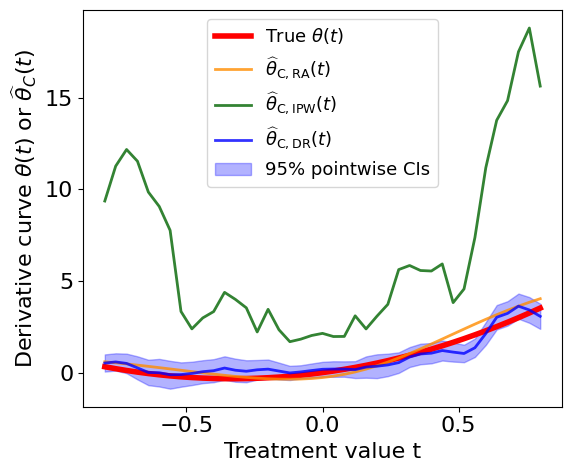

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,5))
plt.plot(t_qry, 2*t_qry + 3*(t_qry**2), linewidth=4, color='red', label=r'True $\theta(t)$')
plt.plot(t_qry, theta_C_RA5, linewidth=2, alpha=0.8, color='darkorange', label=r'$\widehat{\theta}_{\mathrm{C,RA}}(t)$')
plt.plot(t_qry, theta_C_IPW5, linewidth=2, alpha=0.8, color='darkgreen', label=r'$\widehat{\theta}_{\mathrm{C,IPW}}(t)$')
plt.plot(t_qry, theta_C_DR5, linewidth=2, alpha=0.8, color='blue', label=r'$\widehat{\theta}_{\mathrm{C,DR}}(t)$')
plt.fill_between(t_qry, theta_C_DR5 - theta_C_sd5*scipy.stats.norm.ppf(0.975), 
                 theta_C_DR5 + theta_C_sd5*scipy.stats.norm.ppf(0.975), 
                 color='blue', alpha=.3, label='95% pointwise CIs')
plt.legend(fontsize=13)
plt.xlabel('Treatment value t')
plt.ylabel(r'Derivative curve $\theta(t)$ or $\widehat{\theta}_C(t)$')
plt.tight_layout()
plt.show()